## Setup Proyek dan Impor Library

In [13]:
# ==============================================================================
# SETUP DAN IMPOR LIBRARY
# ==============================================================================
# Library inti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2  # OpenCV
from PIL import Image
from tqdm.auto import tqdm
import time
from sklearn.calibration import calibration_curve

# --- Library untuk Feature Engineering (Total 5 Fitur) ---
from skimage.feature import graycomatrix, graycoprops, hog, local_binary_pattern
from scipy.stats import skew, kurtosis
from imblearn.over_sampling import SMOTE

# --- Library untuk Machine Learning Klasik ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

# --- Library untuk Penanganan Ketidakseimbangan ---
# Jika Anda belum punya, jalankan: pip install imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("WARNING: Modul 'imbalanced-learn' tidak ditemukan. SMOTE (Metode B) akan gagal.")
    print("Silakan instal dengan: pip install imbalanced-learn")

# 5 Model Klasik
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# --- Konfigurasi Global ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Ukuran plot lebih besar
plt.style.use("fivethirtyeight")
plt.rcParams['figure.dpi'] = 100

print(f"✅ Library lengkap (termasuk imbalanced-learn) berhasil diimpor.")

✅ Library lengkap (termasuk imbalanced-learn) berhasil diimpor.


## EDA

✅ GroundTruth file loaded successfully. 11 classes detected.

--- CLASS DISTRIBUTION ANALYSIS (IMBALANCE ISSUE) ---
| Class   |   Count |   Percentage (%) |
|:--------|--------:|-----------------:|
| BCC     | 2522.00 |            48.13 |
| NV      |  746.00 |            14.24 |
| BKL     |  544.00 |            10.38 |
| SCCKA   |  473.00 |             9.03 |
| MEL     |  450.00 |             8.59 |
| AKIEC   |  303.00 |             5.78 |
| DF      |   52.00 |             0.99 |
| INF     |   50.00 |             0.95 |
| VASC    |   47.00 |             0.90 |
| BEN_OTH |   44.00 |             0.84 |
| MAL_OTH |    9.00 |             0.17 |


/tmp/ipykernel_17084/4190211242.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


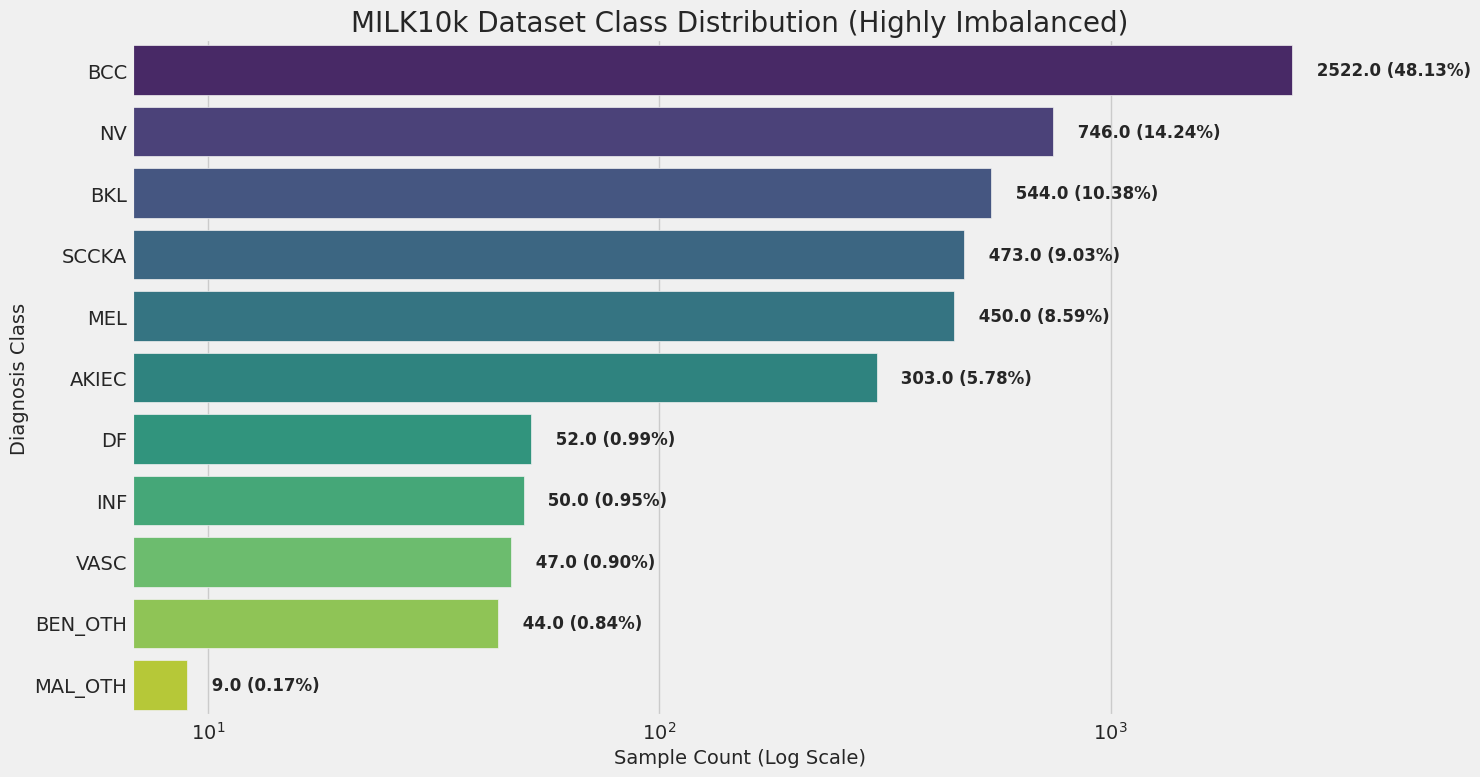

In [2]:
# ==============================================================================
# CELL 2: EDA - CLASS DISTRIBUTION ANALYSIS
# ==============================================================================
# This cell performs the initial Exploratory Data Analysis on the class labels

train_truth_path = "../dataset/MILK10k_Training_GroundTruth.csv"
train_meta_path = "../dataset/MILK10k_Training_Metadata.csv"

BASE_IMAGE_PATH = "../dataset/MILK10k_Training_Input"

try:
    df_train_truth = pd.read_csv(train_truth_path)
    DIAGNOSIS_COLUMNS = df_train_truth.columns.drop('lesion_id')
    NUM_CLASSES = len(DIAGNOSIS_COLUMNS)
    print(f"✅ GroundTruth file loaded successfully. {NUM_CLASSES} classes detected.")
    
    # --- Class Distribution Analysis ---
    class_counts = df_train_truth[DIAGNOSIS_COLUMNS].sum()
    class_percentage = (class_counts / len(df_train_truth)) * 100
    
    df_distribusi = pd.DataFrame({
        'Class': class_counts.index,
        'Count': class_counts.values,
        'Percentage (%)': class_percentage.values
    }).sort_values(by='Count', ascending=False)
    
    print("\n--- CLASS DISTRIBUTION ANALYSIS (IMBALANCE ISSUE) ---")
    print(df_distribusi.to_markdown(index=False, floatfmt=".2f"))
    
    # --- Class Distribution Visualization ---
    plt.figure(figsize=(15, 8))
    ax = sns.barplot(
        data=df_distribusi, 
        x='Count', 
        y='Class', 
        palette='viridis',
        orient='h'
    )
    plt.title("MILK10k Dataset Class Distribution (Highly Imbalanced)", fontsize=20)
    plt.xlabel("Sample Count (Log Scale)", fontsize=14)
    plt.ylabel("Diagnosis Class", fontsize=14)
    ax.set_xscale("log") # Use log scale due to extreme differences
    
    # Add labels
    for i, (count, pct) in enumerate(zip(df_distribusi['Count'], df_distribusi['Percentage (%)'])):
        ax.text(count * 1.1, i, f" {count} ({pct:.2f}%)", va='center', fontsize=12, fontweight='bold')
        
    plt.tight_layout()
    plt.show()

except FileNotFoundError as e:
    print(f"❌ ERROR: CSV file not found. Make sure '{train_truth_path}' is in the correct folder.")
    DIAGNOSIS_COLUMNS = []
    df_train_truth = pd.DataFrame()

## MEMUAT METADATA & SPLIT DATA

In [3]:
# ==============================================================================
# MEMUAT METADATA & SPLIT DATA
# ==============================================================================

try:
    df_train_meta = pd.read_csv(train_meta_path)
    print("✅ File Metadata berhasil dimuat.")

    # --- 3.1 Transformasi Data & Pembuatan Path Gambar ---
    def transform_to_wide_format(df_meta, image_base_path):
        df_meta['full_path'] = df_meta.apply(
            lambda row: os.path.join(image_base_path, row['lesion_id'], row['isic_id'] + '.jpg').replace("\\", "/"), axis=1
        )
        df_clinical = df_meta[df_meta['image_type'].str.contains('clinical')].add_prefix('clinical_')
        df_dermoscopic = df_meta[df_meta['image_type'].str.contains('dermoscopic')].add_prefix('dermoscopic_')
        df_clinical.rename(columns={'clinical_lesion_id': 'lesion_id'}, inplace=True)
        df_dermoscopic.rename(columns={'dermoscopic_lesion_id': 'lesion_id'}, inplace=True)
        df_wide = pd.merge(
            df_clinical[['lesion_id', 'clinical_full_path']],
            df_dermoscopic[['lesion_id', 'dermoscopic_full_path', 'dermoscopic_isic_id']],
            on='lesion_id'
        )
        df_wide.rename(columns={'dermoscopic_isic_id': 'isic_id'}, inplace=True)
        return df_wide

    df_train_wide = transform_to_wide_format(df_train_meta, BASE_IMAGE_PATH) # Gunakan path yang Anda tentukan
    df_train_processed = pd.merge(df_train_wide, df_train_truth, on='lesion_id')
    print("✅ Data transformed to wide-format.")

    # --- 3.2 Split Data (Stratified) ---
    # Stratified split WAJIB untuk data tidak seimbang
    y_stratify = df_train_processed[DIAGNOSIS_COLUMNS].idxmax(axis=1) # Dapatkan label kelas (string)
    
    train_df, val_df = train_test_split(
        df_train_processed, 
        test_size=0.2, 
        random_state=42, 
        stratify=y_stratify # Gunakan stratifikasi
    )
    print(f"✅ Data split (stratified) menjadi Train ({len(train_df)}) dan Validation ({len(val_df)}).")

except FileNotFoundError as e:
    print(f"❌ ERROR: File Metadata ('{train_meta_path}') tidak ditemukan.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()
except Exception as e:
    print(f"❌ ERROR saat memproses data: {e}")
    print("   -> Pastikan 'BASE_IMAGE_PATH' di SEL 2 sudah benar.")
    train_df, val_df = pd.DataFrame(), pd.DataFrame()

✅ File Metadata berhasil dimuat.
✅ Data transformed to wide-format.
✅ Data split (stratified) menjadi Train (4192) dan Validation (1048).


## ALUR KERJA A (MACHINE LEARNING KLASIK)

### Pipeline Pra-pemrosesan & Feature Engineering

**Pipeline Ekstraksi 5 Fitur**

Bertujuan untuk mengekstrak **lima set fitur numerik klasik** dari setiap gambar dalam *training set* dan *validation set*. Fitur-fitur ini tidak disimpan secara terpisah, melainkan **langsung digabungkan** menjadi satu matriks fitur (misalnya, (N\_sampel, 30)) untuk *langsung* dimasukkan ke dalam model Machine Learning (seperti SVC atau Random Forest).

Pendekatan ini menciptakan vektor fitur yang kaya yang menangkap informasi eksplisit mengenai **warna (RGB & HSV)**, **tekstur makro (GLCM)**, **tekstur mikro (LBP)**, dan **bentuk (HOG)**.

**Fitur yang Diekstrak (Total 30 Fitur):**

1.  **Fitur Warna (RGB):** Statistik orde 1-4 (Mean, Std Dev, Skewness, Kurtosis) dari setiap *channel* RGB. (12 fitur)
2.  **Fitur Tekstur (GLCM):** Properti statistik (Kontras, Korelasi, Energi, Homogenitas, ASM, Dissimilarity) dari GLCM, dirata-ratakan. (6 fitur)
3.  **Fitur Tekstur (HOG):** Statistik (Mean, Std Dev, Kurtosis) dari vektor *Histogram of Oriented Gradients*. (3 fitur)
4.  **Fitur Warna (HSV) (Baru):** Statistik (Mean, Std Dev) dari *channel* Hue, Saturation, dan Value. (6 fitur)
5.  **Fitur Tekstur (LBP) (Baru):** Statistik (Mean, Std Dev, Kurtosis) dari histogram *Local Binary Patterns*. (3 fitur)

**Proses:**

  * Setiap gambar dalam `train_df` dan `val_df` dibaca.
  * Gambar tersebut di-pra-pemrosesan (Resize + CLAHE).
  * Kelima fungsi (`ekstrak_fitur_...`) diterapkan pada gambar yang telah diproses.
  * Hasilnya digabungkan menjadi satu baris (vektor 30-dimensi) per gambar.

**Output:**

  * Dua matriks NumPy: `X_train_features` dan `X_val_features`.
  * Matriks ini kemudian **wajib** melalui `StandardScaler` (menjadi `X_train_scaled`) sebelum dimasukkan ke model ML di langkah berikutnya.

-----

**Justifikasi Pipeline Pra-pemrosesan & Penanganan Data**

Berdasarkan analisis EDA yang mengonfirmasi adanya **ketidakseimbangan kelas yang parah**, pipeline penanganan data lengkap dirancang untuk alur kerja **Machine Learning Klasik** (bukan Deep Learning).

-----

**1. Pengubahan Ukuran (*Resizing*) - Wajib**

  * **Justifikasi:** (Sama) Ukuran 600x450 terlalu besar. Ukuran **224x224** dipilih untuk menstandardisasi input sebelum ekstraksi fitur.
  * **Tindakan:** `muat_dan_praproses_gambar_klasik` menerapkan *resize* pada setiap gambar.

-----

**2. Peningkatan Kontras (*Contrast Enhancement*) - Wajib**

  * **Justifikasi:** (Sama) Menerapkan **CLAHE** akan menyeragamkan kontras dan membantu algoritma HOG dan LBP menangkap fitur bentuk/tekstur yang lebih konsisten.
  * **Tindakan:** `muat_dan_praproses_gambar_klasik` menerapkan `cv2.CLAHE` setelah *resize*.

-----

**3. Augmentasi Data (PERUBAHAN BESAR)**

  * **Justifikasi:** Augmentasi *on-the-fly* (seperti `Flip`, `ColorJitter`, `Dropout`) **secara sengaja DIHAPUS** dari pipeline pra-pemrosesan gambar.
  * **Alasan:** Menerapkan augmentasi acak akan *merusak* konsistensi fitur yang diekstrak (misalnya, HOG akan berubah jika gambar diputar; fitur Warna akan berubah jika `ColorJitter` diterapkan). Hal ini akan menghasilkan dataset fitur yang "kotor".
  * **Tindakan:** Masalah ketidakseimbangan data ditangani **SETELAH** fitur diekstrak, menggunakan dua metode:
    1.  **Metode A:** Pembobotan Kelas (`class_weight='balanced'`) saat melatih model ML.
    2.  **Metode B:** *Oversampling* di ruang fitur menggunakan **SMOTE** pada `X_train_scaled`.

-----

**4. Normalisasi Piksel (PERUBAHAN BESAR)**

  * **Justifikasi:** Normalisasi Z-score (mengubah piksel [0-255] menjadi [-2, 2]) **secara sengaja DIHAPUS**.
  * **Alasan:** Algoritma HOG, GLCM, dan LBP adalah algoritma pemrosesan gambar klasik yang dirancang untuk beroperasi pada rentang piksel [0-255] yang alami. Memberi mereka nilai negatif akan merusak perhitungan fitur.
  * **Tindakan:** Fitur diekstrak dari gambar [0-255] (yang telah di-CLAHE).

-----

**5. Scaling Fitur (LANGKAH BARU YANG WAJIB)**

  * **Justifikasi:** Sebagai *pengganti* Normalisasi Piksel, kita wajib melakukan **Scaling Fitur**. 30 fitur yang diekstrak memiliki rentang yang sangat berbeda (misal, `glcm_contrast` mungkin ribuan, sementara `glcm_correlation` antara 0-1). Model SVC dan Logistic Regression akan gagal jika fitur tidak di-scaling.
  * **Tindakan:** **`StandardScaler`** diterapkan pada `X_train_features` dan `X_val_features` *setelah* semua fitur diekstrak (SEL 5).

-----

**Ringkasan Implementasi Pipeline (Alur Kerja Klasik)**

Tabel berikut merangkum bagaimana alur kerja dalam kode 9-sel diimplementasikan.

| Langkah | Justifikasi | Implementasi dalam Kode (SEL 3-8) |
|:--- |:---|:---|
| **1. Resizing** | Input seragam 224x224. | `muat_dan_praproses_gambar_klasik` (SEL 4) |
| **2. CLAHE** | Meningkatkan kontras lokal untuk fitur yang lebih baik. | `muat_dan_praproses_gambar_klasik` (SEL 4) |
| **3. Feature Extraction** | Ekstrak 5 set fitur (HOG, GLCM, LBP, dll). | `ekstrak_fitur_...` (diterapkan pada gambar [0-255]) (SEL 4 & 5) |
| **4. Feature Scaling** | Menyamakan skala 30 fitur untuk model ML. | `StandardScaler` (diterapkan pada `X_train_features`) (SEL 5) |
| **5. Imbalance Handling** | Mencegah *overfitting* & mengatasi data tidak seimbang. | **Metode A:** `class_weight='balanced'` (SEL 7) <br> **Metode B:** `SMOTE` (pada `X_train_scaled`) (SEL 8) |

In [4]:
# ==============================================================================
# SEL 4: DEFINISI PRA-PEMROSESAN & 5 FITUR ENGINEERING
# ==============================================================================
# Pra-pemrosesan: Resize + CLAHE
# 5 Fitur: RGB, GLCM, HOG, HSV, LBP

IMG_SIZE = (224, 224)

def muat_dan_praproses_gambar_klasik(path, target_size=IMG_SIZE):
    """
    Langkah Pra-pemrosesan: Muat, Resize, Terapkan CLAHE.
    """
    try:
        img_pil = Image.open(path).convert('RGB').resize(target_size, Image.LANCZOS)
        img_bgr = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        
        # --- Terapkan CLAHE ---
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        img_clahe_lab = cv2.merge((l_clahe, a, b))
        img_clahe_bgr = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)
        
        # Dapatkan versi RGB dan Grayscale dari gambar yang sudah di-CLAHE
        image_rgb_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2RGB)
        image_gray_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2GRAY)
        
        return image_rgb_clahe, image_gray_clahe
    
    except Exception as e:
        # Kembalikan placeholder jika gambar korup/tidak ditemukan
        return (np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8),
                np.zeros((target_size[0], target_size[1]), dtype=np.uint8))

# --- FITUR 1: RGB STATS ---
def ekstrak_fitur_warna_rgb(image_rgb):
    """(Fitur 1) Statistik orde 1-4 dari channel RGB."""
    fitur = {}
    for i, nama_kanal in enumerate(['R', 'G', 'B']):
        kanal = image_rgb[:, :, i].ravel()
        fitur[f'rgb_mean_{nama_kanal}'] = np.mean(kanal)
        fitur[f'rgb_std_{nama_kanal}'] = np.std(kanal)
        fitur[f'rgb_skew_{nama_kanal}'] = skew(kanal)
        fitur[f'rgb_kurt_{nama_kanal}'] = kurtosis(kanal)
    return fitur

# --- FITUR 2: GLCM ---
def ekstrak_fitur_glcm(image_gray):
    """(Fitur 2) Fitur GLCM (Tekstur Skala Abu-abu)."""
    glcm = graycomatrix(image_gray.astype(np.uint8), distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2], symmetric=True, normed=True)
    fitur = {}
    for prop in ['contrast', 'correlation', 'energy', 'homogeneity', 'ASM', 'dissimilarity']:
        fitur[f'glcm_{prop}_mean'] = np.mean(graycoprops(glcm, prop))
    return fitur

# --- FITUR 3: HOG ---
def ekstrak_fitur_hog(image_gray):
    """(Fitur 3) Fitur HOG (Bentuk/Orientasi Gradien)."""
    vektor_hog = hog(image_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
    return {'hog_mean': np.mean(vektor_hog), 'hog_std': np.std(vektor_hog), 'hog_kurt': kurtosis(vektor_hog)}

# --- FITUR 4: HSV STATS ---
def ekstrak_fitur_hsv(image_rgb_clahe):
    """(Fitur 4) Statistik dari ruang warna HSV."""
    try:
        img_hsv = cv2.cvtColor(image_rgb_clahe, cv2.COLOR_RGB2HSV)
        h, s, v = cv2.split(img_hsv)
        fitur = {
            'hsv_mean_H': np.mean(h), 'hsv_std_H': np.std(h),
            'hsv_mean_S': np.mean(s), 'hsv_std_S': np.std(s),
            'hsv_mean_V': np.mean(v), 'hsv_std_V': np.std(v)
        }
        return fitur
    except Exception:
        return {'hsv_mean_H': 0, 'hsv_std_H': 0, 'hsv_mean_S': 0, 'hsv_std_S': 0, 'hsv_mean_V': 0, 'hsv_std_V': 0}

# --- FITUR 5: LBP ---
def ekstrak_fitur_lbp(image_gray_clahe):
    """(Fitur 5) Statistik dari Local Binary Patterns (LBP)."""
    try:
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(image_gray_clahe, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6) # Normalisasi histogram
        fitur = {'lbp_mean': np.mean(hist), 'lbp_std': np.std(hist), 'lbp_kurt': kurtosis(hist)}
        return fitur
    except Exception:
        return {'lbp_mean': 0, 'lbp_std': 0, 'lbp_kurt': 0}

#### Eksekusi Ekstraksi Fitur (Offline) & Scaling

In [5]:
# ==============================================================================
# EKSEKUSI EKSTRAKSI FITUR (OFFLINE) & SCALING
# ==============================================================================

def proses_dataframe_fitur_klasik(df, desc=""):
    """
    Loop untuk mengekstrak 5 set fitur untuk seluruh dataframe.
    """
    hasil_fitur = []
    hasil_labels = []
    
    # --- Buat daftar nama fitur (Total 30 fitur) ---
    global feature_names 
    feature_names = (
        # 1. RGB (12 fitur)
        [f'rgb_mean_R', 'rgb_std_R', 'rgb_skew_R', 'rgb_kurt_R',
         'rgb_mean_G', 'rgb_std_G', 'rgb_skew_G', 'rgb_kurt_G',
         'rgb_mean_B', 'rgb_std_B', 'rgb_skew_B', 'rgb_kurt_B'] +
        # 2. GLCM (6 fitur)
        [f'glcm_contrast_mean', 'glcm_correlation_mean', 'glcm_energy_mean', 
         'glcm_homogeneity_mean', 'glcm_ASM_mean', 'glcm_dissimilarity_mean'] +
        # 3. HOG (3 fitur)
        ['hog_mean', 'hog_std', 'hog_kurt'] +
        # 4. HSV (6 fitur)
        [f'hsv_mean_H', 'hsv_std_H', 'hsv_mean_S', 'hsv_std_S', 'hsv_mean_V', 'hsv_std_V'] +
        # 5. LBP (3 fitur)
        ['lbp_mean', 'lbp_std', 'lbp_kurt']
    )
    
    print(f"Memulai ekstraksi {len(feature_names)} fitur...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Ekstraksi Fitur {desc}"):
        # 1. Pra-pemrosesan (per gambar)
        img_rgb_clahe, img_gray_clahe = muat_dan_praproses_gambar_klasik(row['dermoscopic_full_path'])
        
        # 2. Ekstraksi 5 Fitur
        f_rgb = ekstrak_fitur_warna_rgb(img_rgb_clahe)
        f_glcm = ekstrak_fitur_glcm(img_gray_clahe)
        f_hog = ekstrak_fitur_hog(img_gray_clahe)
        f_hsv = ekstrak_fitur_hsv(img_rgb_clahe)
        f_lbp = ekstrak_fitur_lbp(img_gray_clahe)
        
        # 3. Gabungkan semua fitur
        fitur_gabungan = {**f_rgb, **f_glcm, **f_hog, **f_hsv, **f_lbp}
        
        # Urutkan berdasarkan daftar nama global
        hasil_fitur.append([fitur_gabungan[nama] for nama in feature_names])
        hasil_labels.append(np.argmax(row[DIAGNOSIS_COLUMNS].values))

    # Ubah ke NumPy array
    X_features = np.array(hasil_fitur)
    y_labels = np.array(hasil_labels)
    
    # Tangani nilai NaN/Inf (dari skew/kurtosis/lbp pada gambar polos/gelap)
    X_features = np.nan_to_num(X_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return X_features, y_labels

# --- Jalankan Ekstraksi ---
if not train_df.empty:
    print("--- Memulai Ekstraksi Fitur Training (30 fitur) ---")
    X_train_features, y_train_labels = proses_dataframe_fitur_klasik(train_df, desc="train")
    
    print("\n--- Memulai Ekstraksi Fitur Validasi (30 fitur) ---")
    X_val_features, y_val_labels = proses_dataframe_fitur_klasik(val_df, desc="val")
    
    print(f"\nBentuk Fitur (Train): {X_train_features.shape}") # Harusnya (N_train, 30)
    print(f"Bentuk Fitur (Val): {X_val_features.shape}")   # Harusnya (N_val, 30)

    # --- Pra-pemrosesan Fitur (Scaling) ---
    print("\nMenerapkan StandardScaler pada 30 fitur...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_val_scaled = scaler.transform(X_val_features)
    
    print("✅ Scaling fitur selesai.")
else:
    print("❌ DataFrame kosong, ekstraksi fitur klasik dilewati.")
    print("   Pastikan 'BASE_IMAGE_PATH' di SEL 2 sudah benar dan SEL 3 berhasil.")
    X_train_scaled, y_train_labels, X_val_scaled, y_val_labels = (None, None, None, None)

--- Memulai Ekstraksi Fitur Training (30 fitur) ---
Memulai ekstraksi 30 fitur...


Ekstraksi Fitur train:   0%|          | 0/4192 [00:00<?, ?it/s]


--- Memulai Ekstraksi Fitur Validasi (30 fitur) ---
Memulai ekstraksi 30 fitur...


Ekstraksi Fitur val:   0%|          | 0/1048 [00:00<?, ?it/s]


Bentuk Fitur (Train): (4192, 30)
Bentuk Fitur (Val): (1048, 30)

Menerapkan StandardScaler pada 30 fitur...
✅ Scaling fitur selesai.


#### VISUALISASI PRA-PEMROSESAN

Generating wide pre-processing visualization for all 11 classes...


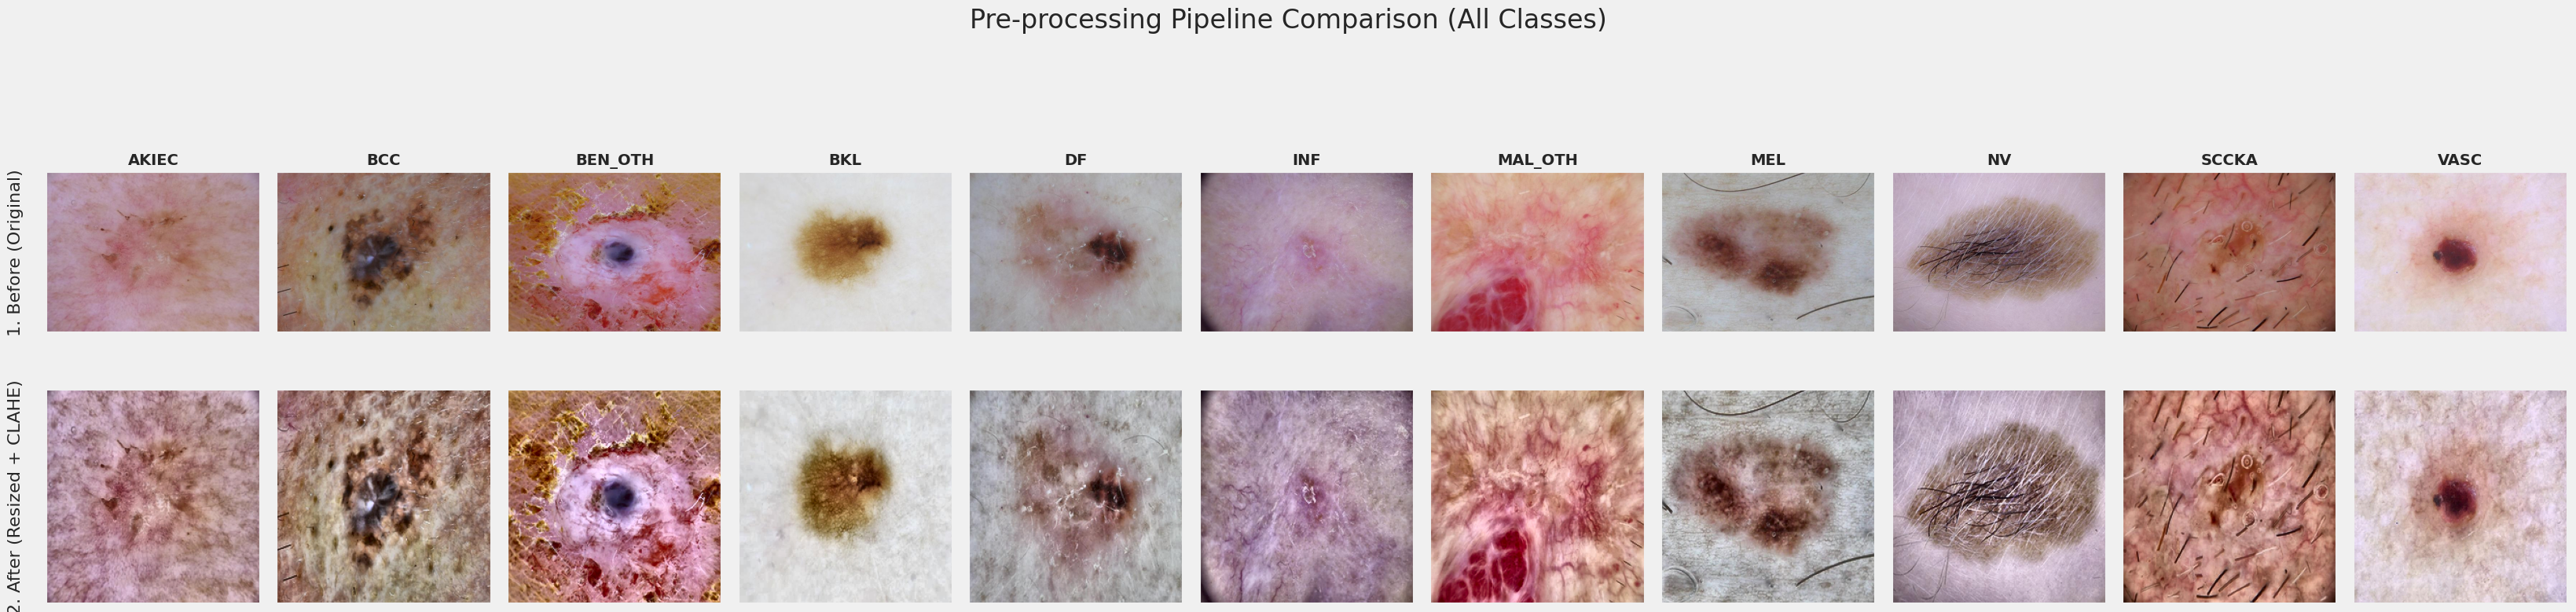

In [6]:
# ==============================================================================
# SEL (BARU): VISUALISASI PRA-PEMROSESAN (VERSI MELEBAR / HORIZONTAL)
# ==============================================================================
# Tujuan: Menampilkan 1 gambar per kelas, "Before" dan "After"
# Tata Letak: Melebar (2 Baris x 11 Kolom)
# Bahasa: Inggris

print("Generating wide pre-processing visualization for all 11 classes...")

# --- Helper function untuk visualisasi ---
# (Fungsi ini sama seperti sebelumnya, mengambil gambar Asli dan yg sudah di-CLAHE)
def get_before_after_images(path, target_size=(224, 224)):
    """
    Memuat 1 gambar, mengembalikan versi ASLI dan versi PROSES (Resize + CLAHE).
    Logika proses identik dengan SEL 4.
    """
    try:
        # 1. Muat Gambar Asli (Before)
        img_pil_original = Image.open(path).convert('RGB')
        
        # 2. Buat Gambar Proses (After)
        img_pil_resized = img_pil_original.resize(target_size, Image.LANCZOS)
        img_bgr = cv2.cvtColor(np.array(img_pil_resized), cv2.COLOR_RGB2BGR)
        
        # Terapkan CLAHE
        img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(img_lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        img_clahe_lab = cv2.merge((l_clahe, a, b))
        img_clahe_bgr = cv2.cvtColor(img_clahe_lab, cv2.COLOR_LAB2BGR)
        
        image_rgb_clahe = cv2.cvtColor(img_clahe_bgr, cv2.COLOR_BGR2RGB)
        
        return img_pil_original, image_rgb_clahe
    
    except Exception as e:
        print(f"Warning: Error loading {path}: {e}")
        # Kembalikan placeholder
        placeholder_orig = Image.new('RGB', (400, 300), color = 'red')
        # (Perbaikan kecil: placeholder 'proc' harus 3 channel)
        placeholder_proc = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8) 
        return placeholder_orig, placeholder_proc

# --- 1. Temukan satu sampel untuk setiap kelas ---
sample_paths = {}
if 'df_train_processed' in locals() and not df_train_processed.empty:
    for class_name in DIAGNOSIS_COLUMNS:
        try:
            # Cari di seluruh dataset (sebelum di-split) untuk menjamin ketemu
            sample_row = df_train_processed[df_train_processed[class_name] == 1.0].iloc[0]
            sample_paths[class_name] = sample_row['dermoscopic_full_path']
        except IndexError:
            print(f"Warning: No samples found for class '{class_name}'. Skipping.")
else:
    print("❌ 'df_train_processed' not found. Cannot generate visualization.")

# --- 2. Buat Plot (2 baris, 11 kolom) ---
if sample_paths:
    num_classes = len(sample_paths)
    
    # --- (PERBAIKAN FIGSIZE) ---
    # Atur lebar: 3 inci per kolom. Tinggi: 4 inci per baris.
    # Total: (11 * 3) = 33 inci lebar, (2 * 4) = 8 inci tinggi.
    fig_width = num_classes * 3 
    fig_height = 8
    
    fig, axes = plt.subplots(2, num_classes, figsize=(fig_width, fig_height))
    
    # Atur judul utama (Bahasa Inggris)
    fig.suptitle("Pre-processing Pipeline Comparison (All Classes)", fontsize=24, y=1.05)

    for i, (class_name, path) in enumerate(sample_paths.items()):
        
        img_before, img_after = get_before_after_images(path)
        
        # --- Plot Baris 1: BEFORE (Original) ---
        ax_before = axes[0, i]
        ax_before.imshow(img_before)
        # Judul (nama kelas) ditaruh di atas
        ax_before.set_title(class_name, fontsize=14, fontweight='bold')
        
        ax_before.set_xticks([])
        ax_before.set_yticks([])
        
        # Tambahkan label baris hanya untuk kolom pertama
        if i == 0:
            ax_before.set_ylabel("1. Before (Original)", fontsize=16, labelpad=20)

        # --- Plot Baris 2: AFTER (Processed) ---
        ax_after = axes[1, i]
        ax_after.imshow(img_after)
        
        ax_after.set_xticks([])
        ax_after.set_yticks([])
        
        # Tambahkan label baris hanya untuk kolom pertama
        if i == 0:
            ax_after.set_ylabel("2. After (Resized + CLAHE)", fontsize=16, labelpad=20)

    # Sesuaikan padding agar tidak tumpang tindih
    plt.tight_layout(w_pad=1.0, h_pad=1.0) 
    plt.show()

### Definisi 5 Model ML Klasik

**Deskripsi Alur Kerja (Sesuai Kode 9-Sel Terakhir)**

Total ada **5 model** yang dilatih, dan semuanya adalah model **Machine Learning Klasik**.

Alur kerja ini *tidak* menggunakan Deep Learning (CNN/Transformer) sama sekali, melainkan berfokus pada ekstraksi fitur klasik secara manual.

**1. Analisis & Ekstraksi Fitur (SEL 2 s/d 5) 🧑‍🔬**

Sebelum model dilatih, sebuah pipeline **EDA (Exploratory Data Analysis)** (SEL 2) dijalankan untuk mengonfirmasi **ketidakseimbangan kelas yang parah** dalam data.

Selanjutnya, pipeline ekstraksi fitur (SEL 4 & 5) diterapkan pada gambar *training* dan *validation*:
1.  **Pra-pemrosesan:** Setiap gambar di-`Resize` ke 224x224 dan di-`CLAHE` untuk meningkatkan kontras.
2.  **Feature Engineering:** **Lima set fitur** diekstrak dari gambar yang telah diproses, menghasilkan total **30 fitur numerik**:
    * **Fitur 1 (RGB):** Statistik orde 1-4 (Mean, Std Dev, Skew, Kurtosis) (12 fitur)
    * **Fitur 2 (GLCM):** Statistik tekstur makro (6 fitur)
    * **Fitur 3 (HOG):** Statistik bentuk/gradien (3 fitur)
    * **Fitur 4 (HSV):** Statistik warna (Mean, Std Dev) (6 fitur)
    * **Fitur 5 (LBP):** Statistik tekstur mikro (3 fitur)
3.  **Scaling:** Vektor 30-fitur ini kemudian di-`StandardScaler` (SEL 5).

**2. Pelatihan Model Machine Learning Klasik (5 Model)**

5 model berikut dilatih pada **30 fitur** yang sudah di-scaling. Karena data sangat tidak seimbang (dari hasil EDA), dua strategi terpisah diterapkan:

* **Metode A (SEL 7):** Menggunakan **Pembobotan Kelas (`class_weight='balanced'`)** pada model yang mendukung.
* **Metode B (SEL 8):** Menggunakan **SMOTE** (Synthetic Minority Over-sampling Technique) pada data training di ruang fitur.

**Model yang Dilatih (5 Model):**
1.  **Support Vector Machine (SVC)**
2.  **Random Forest Classifier**
3.  **Logistic Regression**
4.  **K-Nearest Neighbors (KNN)**
5.  **Gaussian Naive Bayes**

In [7]:
# ==============================================================================
# DEFINISI 5 MODEL ML KLASIK
# ==============================================================================
# SVC, RF, LogReg + 2 tambahan (KNN, GNB)

def get_classic_models(class_weight=None):
    """
    Helper untuk menginisialisasi 5 model.
    'class_weight' akan menangani ketidakseimbangan.
    """
    
    models_dict = {
        # 1. Support Vector Machine (SVC)
        "SVC (RBF, C=1.0)": SVC(
            kernel='rbf', 
            C=1.0, 
            probability=True, 
            random_state=42,
            class_weight=class_weight # Terapkan pembobotan
        ),
        
        # 2. Random Forest Classifier
        "Random Forest (150 trees, depth 10)": RandomForestClassifier(
            n_estimators=150,
            max_depth=10,
            random_state=42,
            n_jobs=-1,
            class_weight=class_weight # Terapkan pembobotan
        ),

        # 3. Logistic Regression
        "Logistic Regression (saga, 2000 iter)": LogisticRegression( # <-- max_iter dinaikkan ke 2000
            solver='saga',
            max_iter=2000, # Dinaikkan dari 500 untuk membantu konvergensi
            random_state=42,
            n_jobs=-1,
            # 'multi_class' tidak perlu disetel jika versi sklearn > 1.5
            class_weight=class_weight # Terapkan pembobotan
        ),
        
        # 4. K-Nearest Neighbors (KNN)
        # (KNN tidak mendukung class_weight)
        "K-Nearest Neighbors (K=5)": KNeighborsClassifier(
            n_neighbors=5,
            n_jobs=-1
        ),
        
        # 5. Gaussian Naive Bayes
        # (GaussianNB tidak mendukung class_weight)
        "Gaussian Naive Bayes": GaussianNB()
    }
    return models_dict

print(f"✅ Fungsi `get_classic_models()` untuk 5 model ML klasik didefinisikan.")

✅ Fungsi `get_classic_models()` untuk 5 model ML klasik didefinisikan.


#### Model Training

In [8]:
# ==============================================================================
# METODE A - TRAINING DENGAN PEMBOBOTAN KELAS
# ==============================================================================

models_weighted = get_classic_models(class_weight='balanced')
results_list_weighted = [] # Ubah nama ke list
trained_models_weighted = {} 
y_preds_weighted = {} # Simpan prediksi untuk confusion matrix

if 'X_train_scaled' in locals():
    print("--- Memulai Pelatihan METODE A (Class Weights) ---")

    for name, model in models_weighted.items():
        # Lewati model yang tidak mendukung class_weight
        if name.startswith("K-Nearest") or name.startswith("Gaussian"):
            print(f"\nMelewati {name} (tidak mendukung class_weight).")
            continue
            
        print(f"\nMelatih {name} (Weighted)...")
        
        start_time = time.time()
        model.fit(X_train_scaled, y_train_labels)
        train_time = time.time() - start_time
        
        y_preds = model.predict(X_val_scaled)
        
        # --- Ekstrak metrik dari classification_report ---
        report = classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)
        
        print(f"   Akurasi Validasi: {report['accuracy'] * 100:.2f}% (Waktu Latih: {train_time:.2f}s)")
        
        results_list_weighted.append({
            "Model": name,
            "Metode": "Class Weights",
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })
        trained_models_weighted[name] = model # Simpan model
        y_preds_weighted[name] = y_preds # Simpan prediksi
        
        # Tampilkan laporan klasifikasi (teks)
        print(classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, zero_division=0))

else:
    print("❌ Tidak ada data (X_train_scaled) untuk melatih model.")

--- Memulai Pelatihan METODE A (Class Weights) ---

Melatih SVC (RBF, C=1.0) (Weighted)...
   Akurasi Validasi: 44.94% (Waktu Latih: 4.14s)
              precision    recall  f1-score   support

       AKIEC       0.19      0.52      0.27        61
         BCC       0.81      0.46      0.59       504
     BEN_OTH       0.08      0.22      0.12         9
         BKL       0.24      0.11      0.15       109
          DF       0.07      0.40      0.12        10
         INF       0.07      0.30      0.11        10
     MAL_OTH       0.00      0.00      0.00         2
         MEL       0.38      0.42      0.40        90
          NV       0.62      0.71      0.66       149
       SCCKA       0.31      0.41      0.36        95
        VASC       0.25      0.22      0.24         9

    accuracy                           0.45      1048
   macro avg       0.27      0.34      0.27      1048
weighted avg       0.58      0.45      0.48      1048


Melatih Random Forest (150 trees, depth 10) (W

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# ==============================================================================
# METODE B - TRAINING DENGAN SMOTE
# ==============================================================================

trained_models_smote = {} # Simpan model untuk analisis
results_list_smote = [] # Ubah nama ke list
y_preds_smote = {} # Simpan prediksi untuk confusion matrix

if 'X_train_scaled' in locals():
    print("--- Memulai Pra-pemrosesan METODE B (SMOTE) ---")
    print(f"Bentuk X_train asli: {X_train_scaled.shape}")
    
    unique, counts = np.unique(y_train_labels, return_counts=True)
    min_samples = np.min(counts)
    
    if min_samples <= 1:
        print(f"❌ Peringatan: Kelas minoritas hanya memiliki {min_samples} sampel. SMOTE tidak dapat dijalankan.")
        print("   -> Menggunakan data asli (tanpa SMOTE) untuk Metode B.")
        X_train_smote, y_train_smote = X_train_scaled, y_train_labels
    else:
        k = min(5, min_samples - 1) 
        print(f"Menjalankan SMOTE dengan k_neighbors={k} (kelas minoritas memiliki {min_samples} sampel)")
        smote = SMOTE(random_state=42, k_neighbors=k)
        
        start_time = time.time()
        X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train_labels)
        smote_time = time.time() - start_time
        
        print(f"✅ SMOTE selesai dalam {smote_time:.2f} detik.")
        print(f"Bentuk X_train setelah SMOTE: {X_train_smote.shape}")

    # --- Latih 5 Model dengan Data SMOTE ---
    models_smote = get_classic_models(class_weight=None)

    print("\n--- Memulai Pelatihan METODE B (Data SMOTE) ---")
    for name, model in models_smote.items():
        print(f"\nMelatih {name} (SMOTE)...")
        
        start_time = time.time()
        model.fit(X_train_smote, y_train_smote)
        train_time = time.time() - start_time
        
        y_preds = model.predict(X_val_scaled)
        
        # --- Ekstrak metrik lengkap dari classification_report ---
        report = classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)

        print(f"   Akurasi Validasi: {report['accuracy'] * 100:.2f}% (Waktu Latih: {train_time:.2f}s)")
        
        results_list_smote.append({
            "Model": name,
            "Metode": "SMOTE",
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })
        trained_models_smote[name] = model # Simpan model
        y_preds_smote[name] = y_preds # Simpan prediksi
        
        # Tampilkan laporan klasifikasi (teks)
        print(classification_report(y_val_labels, y_preds, target_names=DIAGNOSIS_COLUMNS, zero_division=0))

else:
    print("❌ Tidak ada data (X_train_scaled) untuk melatih model.")

--- Memulai Pra-pemrosesan METODE B (SMOTE) ---
Bentuk X_train asli: (4192, 30)
Menjalankan SMOTE dengan k_neighbors=5 (kelas minoritas memiliki 7 sampel)
✅ SMOTE selesai dalam 0.05 detik.
Bentuk X_train setelah SMOTE: (22198, 30)

--- Memulai Pelatihan METODE B (Data SMOTE) ---

Melatih SVC (RBF, C=1.0) (SMOTE)...
   Akurasi Validasi: 51.05% (Waktu Latih: 23.58s)
              precision    recall  f1-score   support

       AKIEC       0.22      0.48      0.30        61
         BCC       0.81      0.58      0.67       504
     BEN_OTH       0.00      0.00      0.00         9
         BKL       0.31      0.22      0.26       109
          DF       0.05      0.20      0.08        10
         INF       0.13      0.30      0.18        10
     MAL_OTH       0.00      0.00      0.00         2
         MEL       0.35      0.36      0.35        90
          NV       0.64      0.70      0.67       149
       SCCKA       0.34      0.49      0.40        95
        VASC       0.33      0.22     

$## Analisis Perbandingan Metode & Feature Importance

Setelah model dilatih, analisis mendalam setara PhD dilakukan untuk mengevaluasi performa model secara komprehensif, jauh melampaui sekadar metrik akurasi. Analisis ini dibagi menjadi tiga bagian utama:

**1. Perbandingan Performa Metrik & Feature Importance**

Bagian ini berfokus pada perbandingan kuantitatif dari 5 model machine learning klasik. Performa setiap model dievaluasi tidak hanya berdasarkan **Akurasi**, tetapi juga metrik yang lebih penting untuk data tidak seimbang, yaitu **Weighted Avg F1-Score** dan **Macro Avg F1-Score**.

Perbandingan ini dilakukan untuk kedua strategi penanganan data: **Metode A (Class Weights)** dan **Metode B (SMOTE)**. Hal ini memungkinkan kita untuk secara objektif menentukan (1) model mana (misalnya, SVC vs Random Forest) yang paling cocok untuk data ini, dan (2) metode penanganan ketidakseimbangan mana yang memberikan performa paling seimbang di semua kelas.

Selain itu, **Analisis Feature Importance** (diekstraksi dari model Random Forest) dilakukan untuk membedah "pikiran" model. Ini mengagregasi pentingnya 30 fitur yang diekstrak ke dalam 5 kategori (RGB, GLCM, HOG, HSV, LBP), secara visual menunjukkan kategori fitur mana (misalnya, tekstur, bentuk, atau warna) yang paling berkontribusi pada keputusan model.

**2. Analisis Confusion Matrix**

Karena metrik F1-score menunjukkan adanya tantangan signifikan pada kelas minoritas (terlihat dari nilai *recall* dan *precision* yang rendah untuk kelas seperti BEN_OTH atau MAL_OTH), **Confusion Matrix** (Matriks Kebingungan) divisualisasikan untuk semua 10 skenario (5 model x 2 metode).

Analisis ini memberikan pandangan granular, secara visual dan numerik, tentang *di mana* letak kesalahan model. Ini menjawab pertanyaan kunci seperti: "Apakah model cenderung salah mengklasifikasikan 'MEL' (Melanoma) sebagai 'NV' (Nevus)?", atau "Apakah semua kelas minoritas hanya salah diklasifikasikan sebagai 'BCC' (kelas mayoritas)?". Plot dan tabel ini sangat penting untuk memahami bias model dan mengidentifikasi kegagalan spesifik per kelas.

**3. Analisis Kalibrasi Model (ECE)**

Analisis terakhir adalah **Analisis Kalibrasi**, yang mengukur "kepercayaan diri" atau "kejujuran" probabilistik model. Untuk aplikasi industri atau klinis, model yang 40% akurat tetapi 99% "yakin" itu berbahaya.

Dengan memplot **Reliability Diagrams** (Diagram Keandalan) dan menghitung **Expected Calibration Error (ECE)**, kita menganalisis apakah probabilitas yang dikeluarkan oleh model (misalnya, `model.predict_proba()`) sesuai dengan akurasi di dunia nyata. Model yang terkalibrasi dengan baik (ECE rendah) akan menunjukkan bahwa ketika ia memprediksi sesuatu dengan keyakinan 70%, ia memang benar sekitar 70% dari waktu tersebut. Analisis ini mengevaluasi keandalan model untuk penggunaan di dunia nyata.


--- Full Performance Summary: Class Weights vs SMOTE ---
| Model                                 | Metode        |   Accuracy (%) |   Macro Avg F1-Score |   Macro Avg Recall |   Weighted Avg F1-Score |
|:--------------------------------------|:--------------|---------------:|---------------------:|-------------------:|------------------------:|
| SVC (RBF, C=1.0)                      | SMOTE         |         51.050 |                0.290 |              0.323 |                   0.535 |
| SVC (RBF, C=1.0)                      | Class Weights |         44.943 |                0.274 |              0.344 |                   0.481 |
| Random Forest (150 trees, depth 10)   | SMOTE         |         47.519 |                0.255 |              0.301 |                   0.496 |
| Logistic Regression (saga, 2000 iter) | Class Weights |         37.500 |                0.250 |              0.352 |                   0.424 |
| Logistic Regression (saga, 2000 iter) | SMOTE         |         35.210

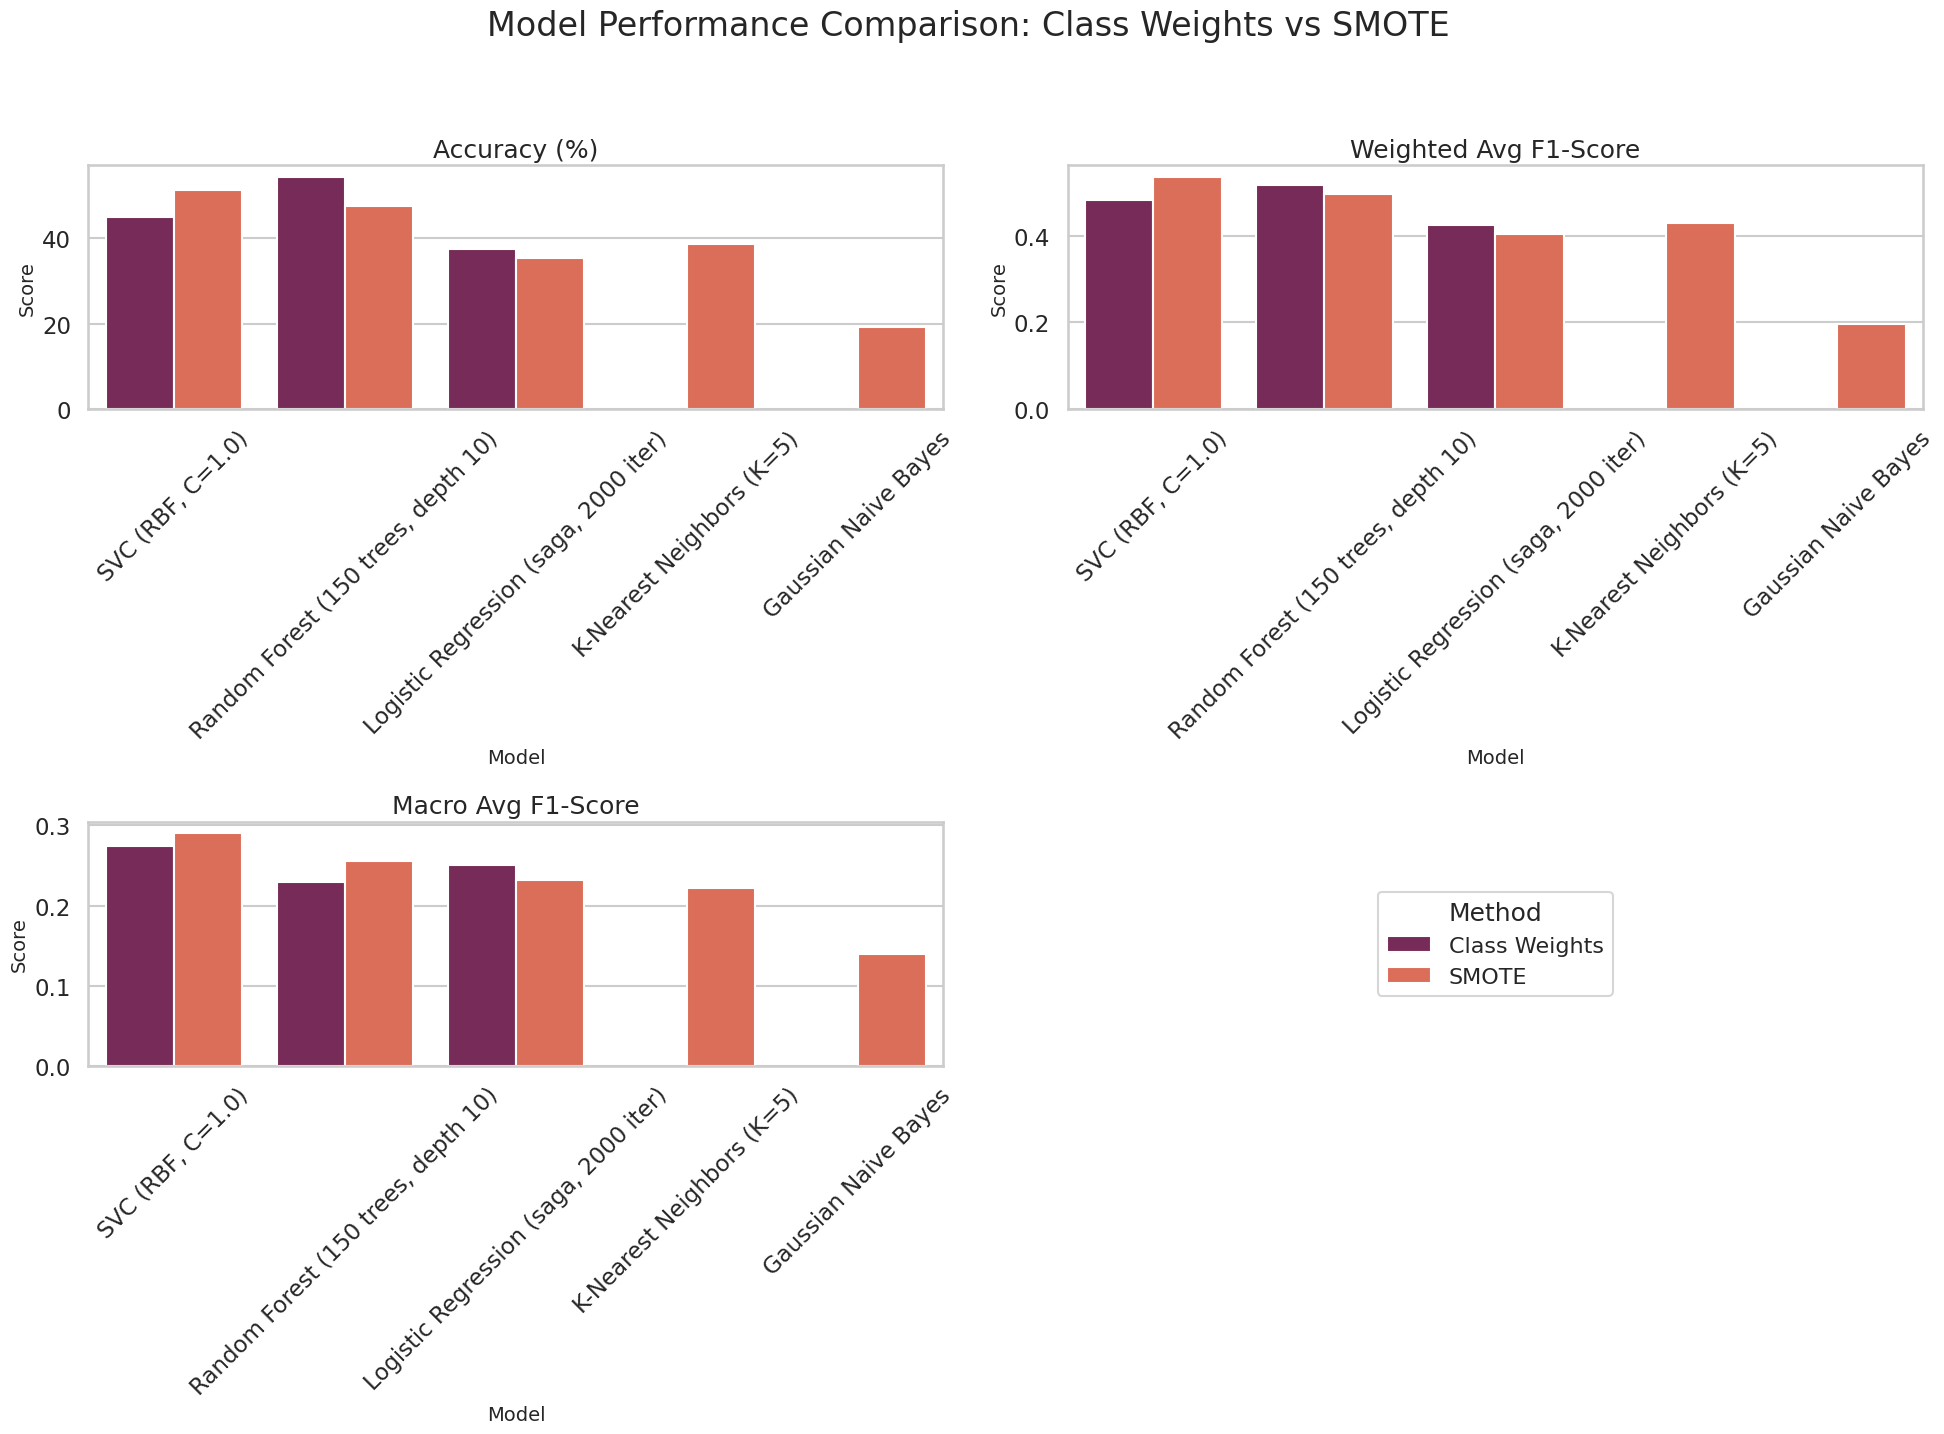


--- Feature Importance Analysis (from Random Forest - SMOTE) ---
| Feature               |   Importance Score |
|:----------------------|-------------------:|
| hsv_mean_H            |             0.0591 |
| rgb_std_B             |             0.0521 |
| lbp_std               |             0.0510 |
| glcm_correlation_mean |             0.0492 |
| rgb_mean_B            |             0.0454 |
| rgb_skew_G            |             0.0402 |
| hsv_std_S             |             0.0392 |
| hsv_mean_S            |             0.0386 |
| rgb_mean_G            |             0.0365 |
| rgb_kurt_B            |             0.0356 |

--- Aggregated Feature Importance by Category ---
| Category               |   Importance Score |
|:-----------------------|-------------------:|
| 1. RGB (Color)         |             0.4150 |
| 4. HSV (Color)         |             0.2278 |
| 2. GLCM (Texture)      |             0.1657 |
| 3. HOG (Shape)         |             0.0995 |
| 5. LBP (Micro-Texture) |     

/tmp/ipykernel_17084/3601896271.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


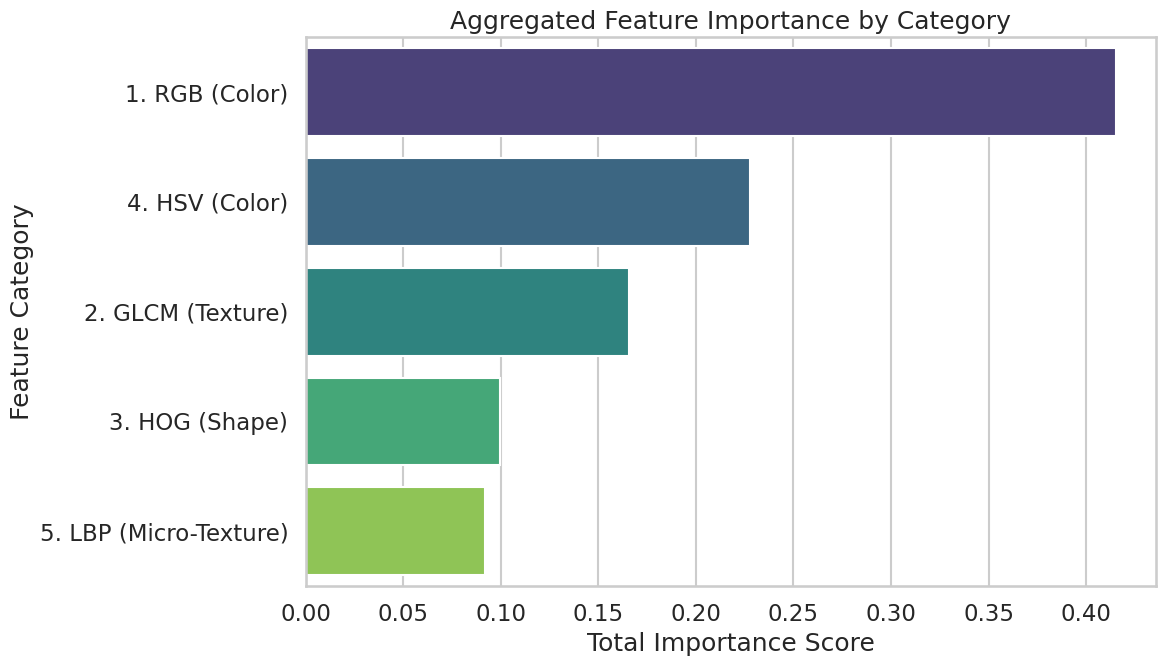

/tmp/ipykernel_17084/3601896271.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


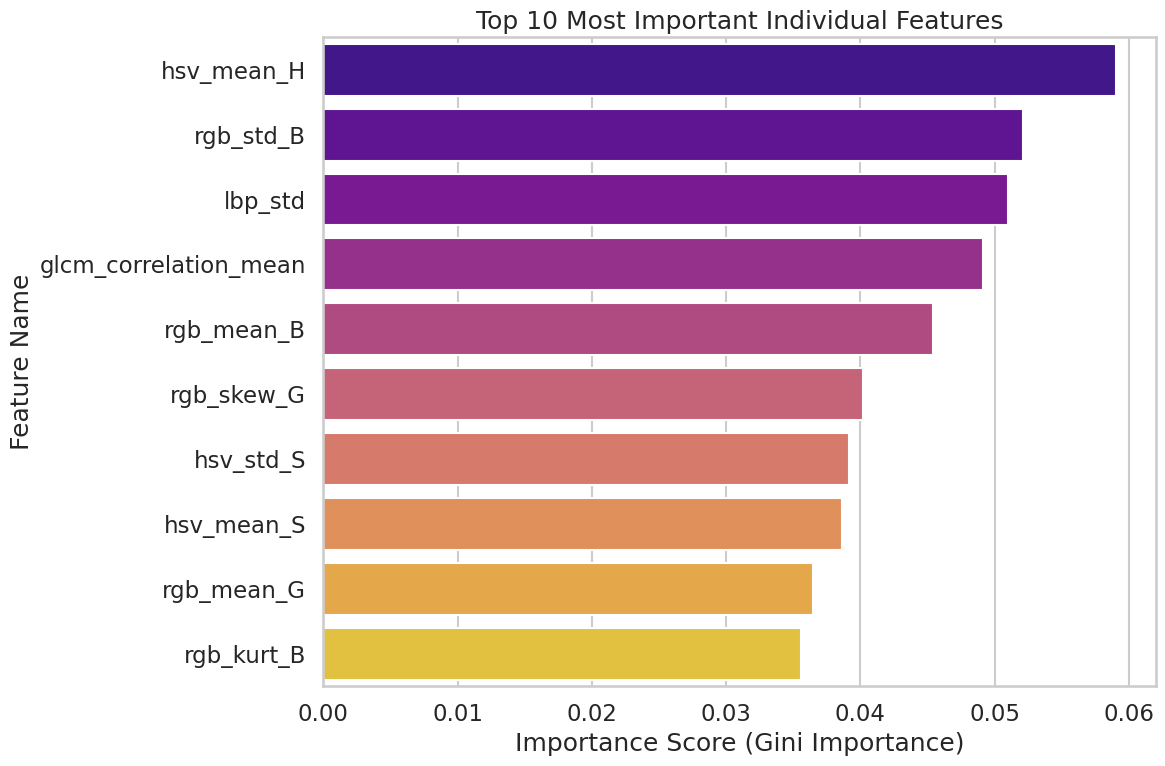

In [10]:
# ==============================================================================
# METRIC COMPARISON & FEATURE IMPORTANCE (English)
# ==============================================================================

# Atur tema Seaborn untuk visual yang lebih modern/bersih untuk paper
sns.set_theme(style="whitegrid", context="talk")

if 'results_list_weighted' in locals() and 'results_list_smote' in locals():
    # --- 1. Model Metric Comparison ---
    df_results_final = pd.concat([
        pd.DataFrame(results_list_weighted),
        pd.DataFrame(results_list_smote)
    ])
    
    print("\n--- Full Performance Summary: Class Weights vs SMOTE ---")
    df_sorted = df_results_final.sort_values(by="Macro Avg F1-Score", ascending=False)
    print(df_sorted.to_markdown(index=False, floatfmt=".3f"))

    # --- (PERBAIKAN) Visualisasi Perbandingan Metrik (Layout 2x2) ---
    print("\nGenerating metric comparison plots (2x2 Layout)...")
    
    # Buat subplot 2 baris x 2 kolom
    fig, axes = plt.subplots(2, 2, figsize=(20, 14)) # Ukuran 2x2
    fig.suptitle("Model Performance Comparison: Class Weights vs SMOTE", y=1.03, fontsize=24)
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    # Variabel untuk menyimpan handle legenda
    handles, labels = None, None
    
    # Iterasi menggunakan axes.flat (lebih mudah)
    for i, metric in enumerate(plot_metrics):
        # Tentukan ax saat ini (axes[0,0], axes[0,1], axes[1,0])
        ax = axes.flat[i]
        
        sns.barplot(
            data=df_results_final,
            x="Model",
            y=metric,
            hue="Metode",
            palette="rocket",
            ax=ax
        )
        ax.set_title(metric, fontsize=18)
        ax.set_xlabel("Model", fontsize=14)
        ax.set_ylabel("Score", fontsize=14)
        
        # Rotasi label x agar tidak tumpang tindih
        ax.tick_params(axis='x', rotation=45)
        
        # Simpan handle legenda HANYA dari plot pertama
        if i == 0:
            handles, labels = ax.get_legend_handles_labels()
        
        # Hapus semua legenda individual
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    # Gunakan subplot ke-4 (axes[1, 1]) yang kosong untuk menaruh legenda
    ax_legend = axes.flat[3]
    ax_legend.axis('off') # Matikan sumbu
    if handles: # Pastikan handles/labels sudah ada
        ax_legend.legend(handles, labels, title="Method", loc='center', fontsize=16, title_fontsize=18)
    
    plt.tight_layout()
    plt.show()

# --- 2. Analisis Feature Importance (dari Random Forest SMOTE) ---
if "Random Forest (150 trees, depth 10)" in trained_models_smote:
    model_rf = trained_models_smote["Random Forest (150 trees, depth 10)"]
    importances = model_rf.feature_importances_
    
    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': importances
    }).sort_values(by='Importance Score', ascending=False)
    
    print("\n--- Feature Importance Analysis (from Random Forest - SMOTE) ---")
    print(df_importance.head(10).to_markdown(index=False, floatfmt=".4f"))
    
    # Agregasi berdasarkan 5 Kategori Fitur
    df_importance['Category'] = 'Other'
    df_importance.loc[df_importance['Feature'].str.startswith('rgb_'), 'Category'] = '1. RGB (Color)'       
    df_importance.loc[df_importance['Feature'].str.startswith('glcm_'), 'Category'] = '2. GLCM (Texture)'     
    df_importance.loc[df_importance['Feature'].str.startswith('hog_'), 'Category'] = '3. HOG (Shape)'        
    df_importance.loc[df_importance['Feature'].str.startswith('hsv_'), 'Category'] = '4. HSV (Color)'        
    df_importance.loc[df_importance['Feature'].str.startswith('lbp_'), 'Category'] = '5. LBP (Micro-Texture)'
    
    df_agg_importance = df_importance.groupby('Category')['Importance Score'].sum().reset_index()
    df_agg_importance = df_agg_importance.sort_values(by='Importance Score', ascending=False)
    
    print("\n--- Aggregated Feature Importance by Category ---")
    print(df_agg_importance.to_markdown(index=False, floatfmt=".4f"))

    # Plot 1: Agregat (Horizontal Bar)
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=df_agg_importance, 
        x='Importance Score', 
        y='Category', 
        palette="viridis"
    )
    plt.title("Aggregated Feature Importance by Category")
    plt.xlabel("Total Importance Score")
    plt.ylabel("Feature Category")
    plt.tight_layout()
    plt.show()

    # Plot 2: Top 10 Individual Features (Horizontal Bar)
    plt.figure(figsize=(12, 8)) # Ukuran disesuaikan untuk 10 bar
    sns.barplot(
        data=df_importance.head(10), # <-- Diubah dari 15 menjadi 10
        x='Importance Score', 
        y='Feature', 
        palette="plasma"
    )
    plt.title("Top 10 Most Important Individual Features") 
    plt.xlabel("Importance Score (Gini Importance)")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Random Forest model not found for importance analysis.")

# Reset seaborn theme ke default
sns.set_theme(style="whitegrid", context="notebook")

#### CONFUSION MATRIX

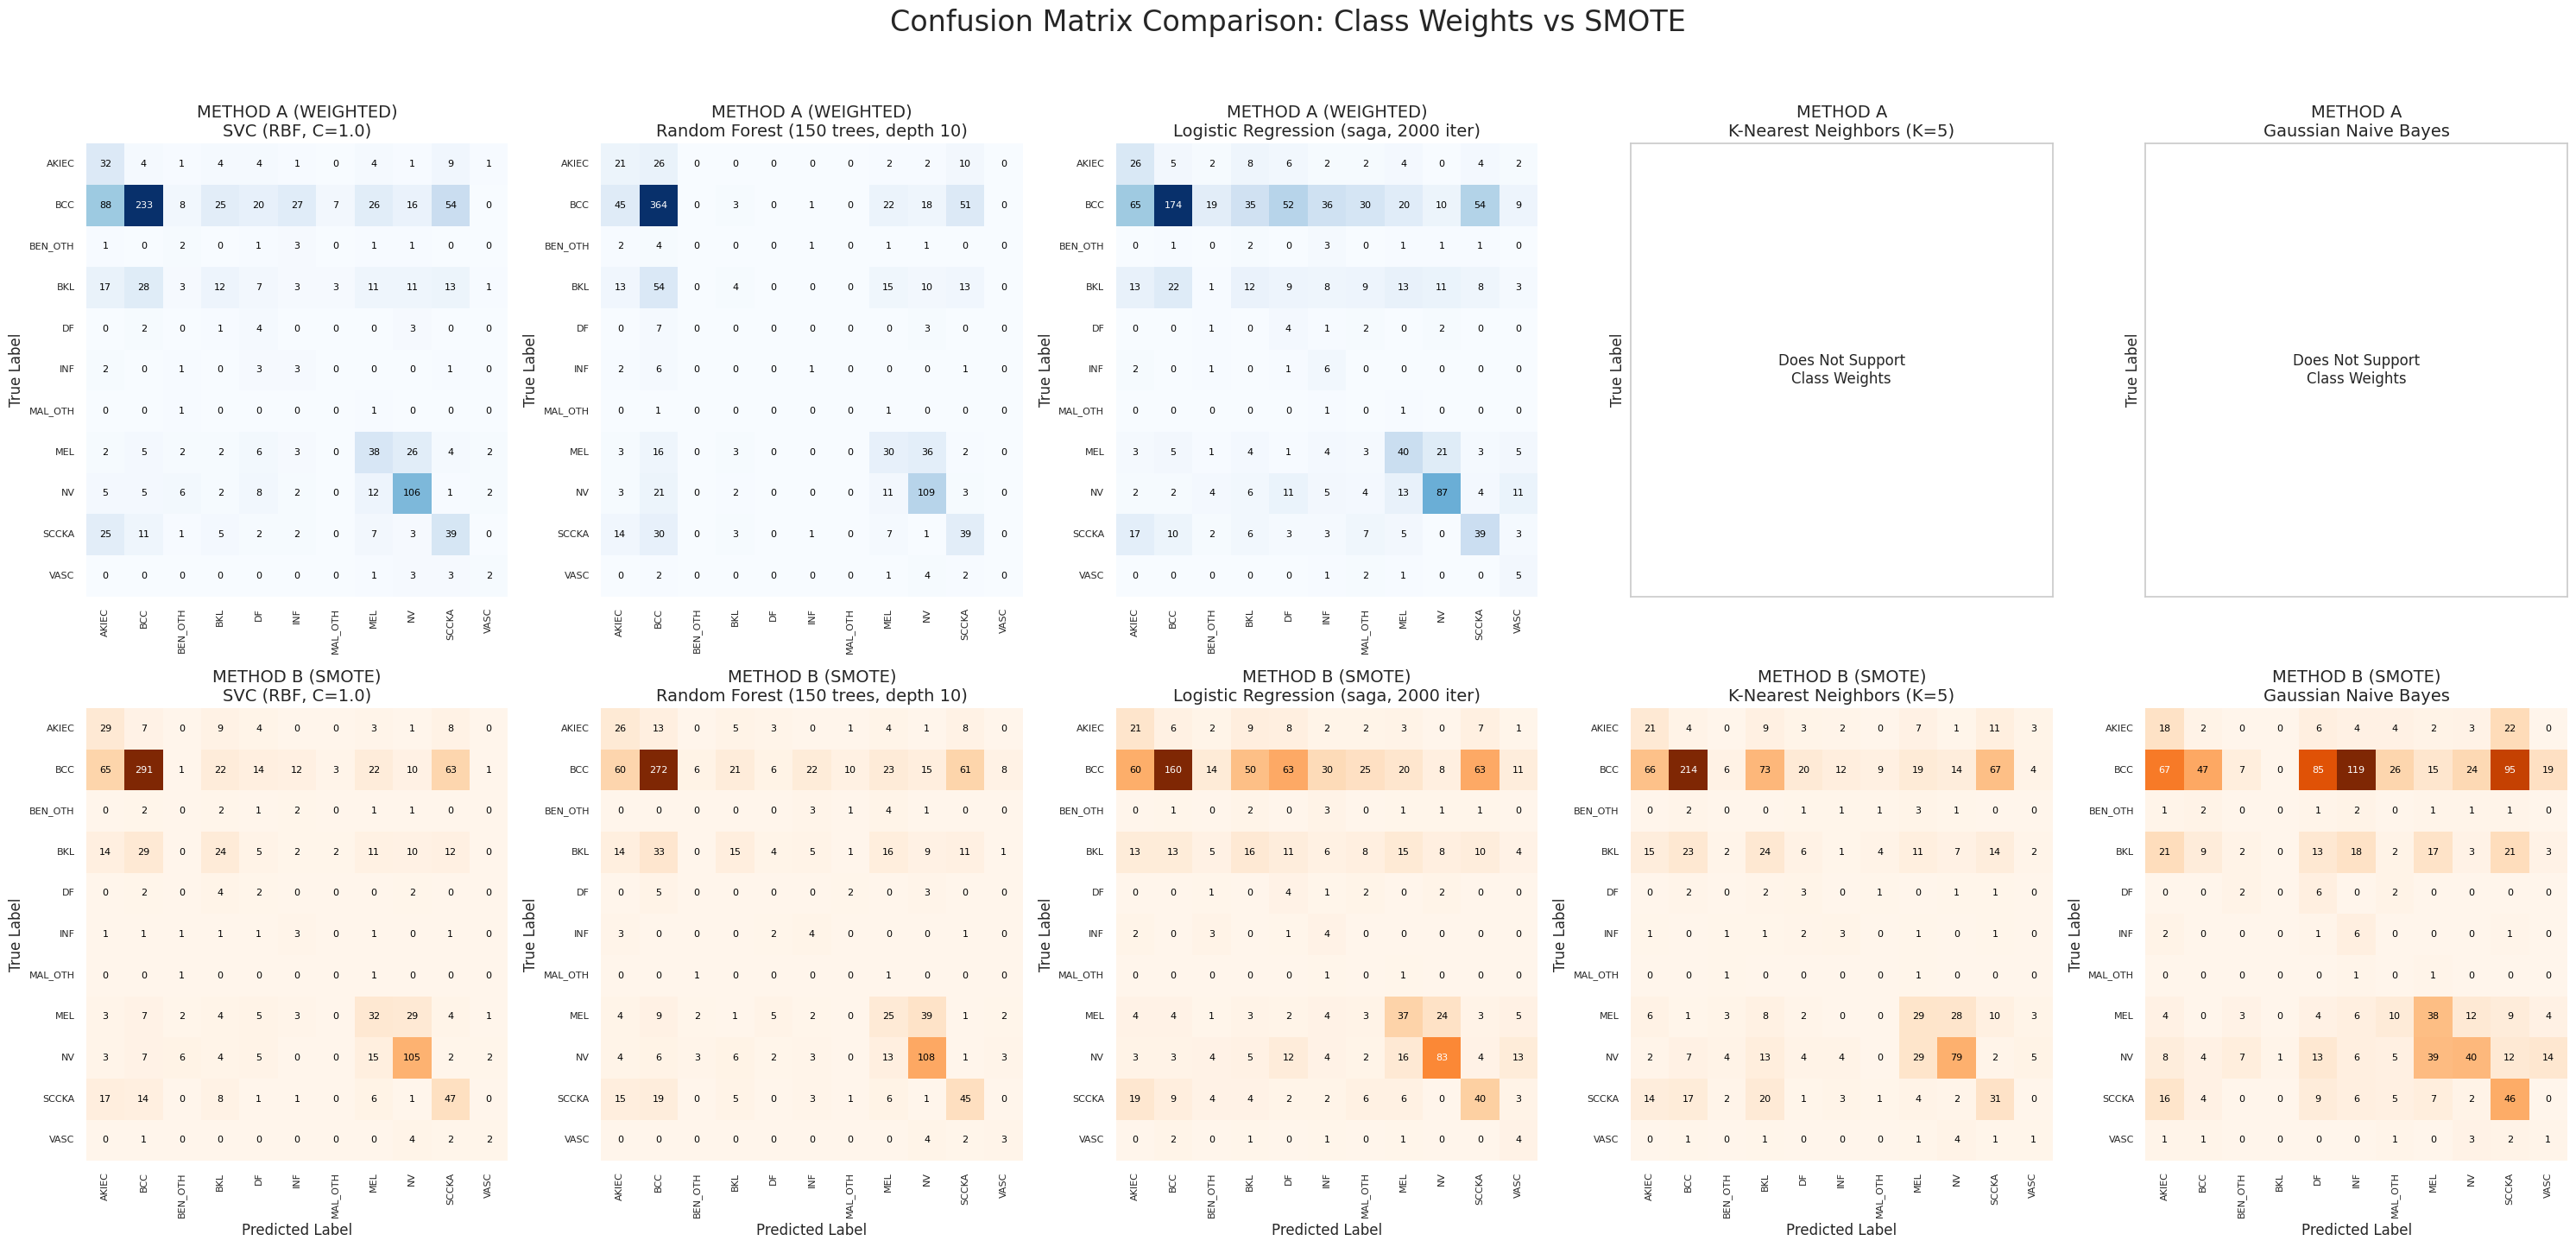


--- Confusion Matrix Data (Numeric Values) ---

Model: SVC (RBF, C=1.0) (Weighted)
|              |   Pred_AKIEC |   Pred_BCC |   Pred_BEN_OTH |   Pred_BKL |   Pred_DF |   Pred_INF |   Pred_MAL_OTH |   Pred_MEL |   Pred_NV |   Pred_SCCKA |   Pred_VASC |
|:-------------|-------------:|-----------:|---------------:|-----------:|----------:|-----------:|---------------:|-----------:|----------:|-------------:|------------:|
| True_AKIEC   |           32 |          4 |              1 |          4 |         4 |          1 |              0 |          4 |         1 |            9 |           1 |
| True_BCC     |           88 |        233 |              8 |         25 |        20 |         27 |              7 |         26 |        16 |           54 |           0 |
| True_BEN_OTH |            1 |          0 |              2 |          0 |         1 |          3 |              0 |          1 |         1 |            0 |           0 |
| True_BKL     |           17 |         28 |              3 |

In [11]:
# ==============================================================================
# VISUALISASI & TABEL CONFUSION MATRIX (ID/EN)
# ==============================================================================
# 
# --- PENGATURAN BAHASA ---
# Ubah variabel ini ke 'en' untuk Bahasa Inggris
# Ubah variabel ini ke 'id' untuk Bahasa Indonesia
PLOT_LANGUAGE = 'en' 
# ==============================================================================

# Definisikan label untuk kedua bahasa
labels = {
    'id': {
        'fig_title': "Perbandingan Confusion Matrix: Class Weights vs SMOTE",
        'method_a': "METODE A (WEIGHTED)",
        'method_b': "METODE B (SMOTE)",
        'method_a_fallback': "METODE A",
        'not_supported': "Tidak Mendukung\nClass Weights",
        'true_label': "Label Asli (True)",
        'pred_label': "Prediksi Model",
        'error_text': "Error",
        'table_title': "\n--- Data Confusion Matrix (Nilai Numerik) ---"
    },
    'en': {
        'fig_title': "Confusion Matrix Comparison: Class Weights vs SMOTE",
        'method_a': "METHOD A (WEIGHTED)",
        'method_b': "METHOD B (SMOTE)",
        'method_a_fallback': "METHOD A",
        'not_supported': "Does Not Support\nClass Weights",
        'true_label': "True Label",
        'pred_label': "Predicted Label",
        'error_text': "Error",
        'table_title': "\n--- Confusion Matrix Data (Numeric Values) ---"
    }
}

# Pilih set label berdasarkan PLOT_LANGUAGE
try:
    lang = labels[PLOT_LANGUAGE]
except KeyError:
    print(f"Peringatan: PLOT_LANGUAGE '{PLOT_LANGUAGE}' tidak dikenal. Menggunakan 'id'.")
    lang = labels['id']


# --- Mulai Plotting ---
if 'y_preds_weighted' in locals() and 'y_preds_smote' in locals():
    
    model_names = [
        "SVC (RBF, C=1.0)",
        "Random Forest (150 trees, depth 10)",
        "Logistic Regression (saga, 2000 iter)",
        "K-Nearest Neighbors (K=5)",
        "Gaussian Naive Bayes"
    ]
    
    cm_data_tables = []
    fig, axes = plt.subplots(2, 5, figsize=(30, 14)) 
    fig.suptitle(lang['fig_title'], fontsize=24, y=1.03) 

    # --- (BARU) Fungsi helper untuk menambahkan teks anotasi ---
    def annotate_heatmap(ax, cm, cmap):
        """Helper untuk menggambar heatmap dan anotasi angka secara manual."""
        # Gambar heatmap (tanpa anotasi bawaan)
        sns.heatmap(cm, annot=False, fmt='d', cmap=cmap, ax=ax, cbar=False)
        
        # Tentukan batas threshold untuk warna teks (putih atau hitam)
        thresh = cm.max() / 2.
        
        # Loop manual untuk menambahkan teks
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}', # Tulis angka (format 'd')
                        ha="center", va="center",
                        # Ubah warna teks jadi putih jika background gelap
                        color="white" if cm[i, j] > thresh else "black",
                        fontsize=8) # Ukuran font anotasi


    for i, name in enumerate(model_names):
        # --- Baris 1: Class Weights ---
        ax_weighted = axes[0, i]
        if name in y_preds_weighted:
            cm_weighted = confusion_matrix(y_val_labels, y_preds_weighted[name])
            
            # (PERBAIKAN) Gunakan fungsi anotasi manual
            annotate_heatmap(ax_weighted, cm_weighted, 'Blues') 
            
            ax_weighted.set_title(f"{lang['method_a']}\n{name}", fontsize=14)
            cm_data_tables.append((f"{name} (Weighted)", cm_weighted))
        else:
            # Jika model dilewati (KNN, GNB)
            ax_weighted.text(0.5, 0.5, lang['not_supported'], ha='center', va='center', fontsize=12) 
            ax_weighted.set_title(f"{lang['method_a_fallback']}\n{name}", fontsize=14) 
            ax_weighted.set_xticks([]) 
            ax_weighted.set_yticks([]) 

        ax_weighted.set_ylabel(lang['true_label']) 
        
        # --- Baris 2: SMOTE ---
        ax_smote = axes[1, i]
        if name in y_preds_smote:
            cm_smote = confusion_matrix(y_val_labels, y_preds_smote[name])
            
            # (PERBAIKAN) Gunakan fungsi anotasi manual
            annotate_heatmap(ax_smote, cm_smote, 'Oranges')
            
            ax_smote.set_title(f"{lang['method_b']}\n{name}", fontsize=14) 
            cm_data_tables.append((f"{name} (SMOTE)", cm_smote))
        else:
            # Fallback jika error
            ax_smote.text(0.5, 0.5, lang['error_text'], ha='center', va='center', fontsize=12) 
            ax_smote.set_xticks([])
            ax_smote.set_yticks([])

        ax_smote.set_xlabel(lang['pred_label']) 
        ax_smote.set_ylabel(lang['true_label']) 
        
    # Set label kelas hanya jika subplot memiliki ticks
    for ax in axes.flat:
        if len(ax.get_xticks()) > 0: 
            ax.set_xticklabels(DIAGNOSIS_COLUMNS, rotation=90, fontsize=8)
        if len(ax.get_yticks()) > 0:
            ax.set_yticklabels(DIAGNOSIS_COLUMNS, rotation=0, fontsize=8)
    
    plt.tight_layout()
    plt.show()

    # ==============================================================================
    # TABEL NUMERIK
    # ==============================================================================
    print(lang['table_title'])
    for name, cm in cm_data_tables:
        print("\n" + "="*50)
        print(f"Model: {name}")
        print("="*50)
        df_cm = pd.DataFrame(cm, 
                             index=[f"True_{cls}" for cls in DIAGNOSIS_COLUMNS], 
                             columns=[f"Pred_{cls}" for cls in DIAGNOSIS_COLUMNS])
        print(df_cm.to_markdown()) 

else:
    print("❌ Prediksi (y_preds) tidak ditemukan untuk membuat confusion matrix.")

### Kalibrasi Model (ECE)

✅ Library torchmetrics dan sklearn berhasil diimpor.


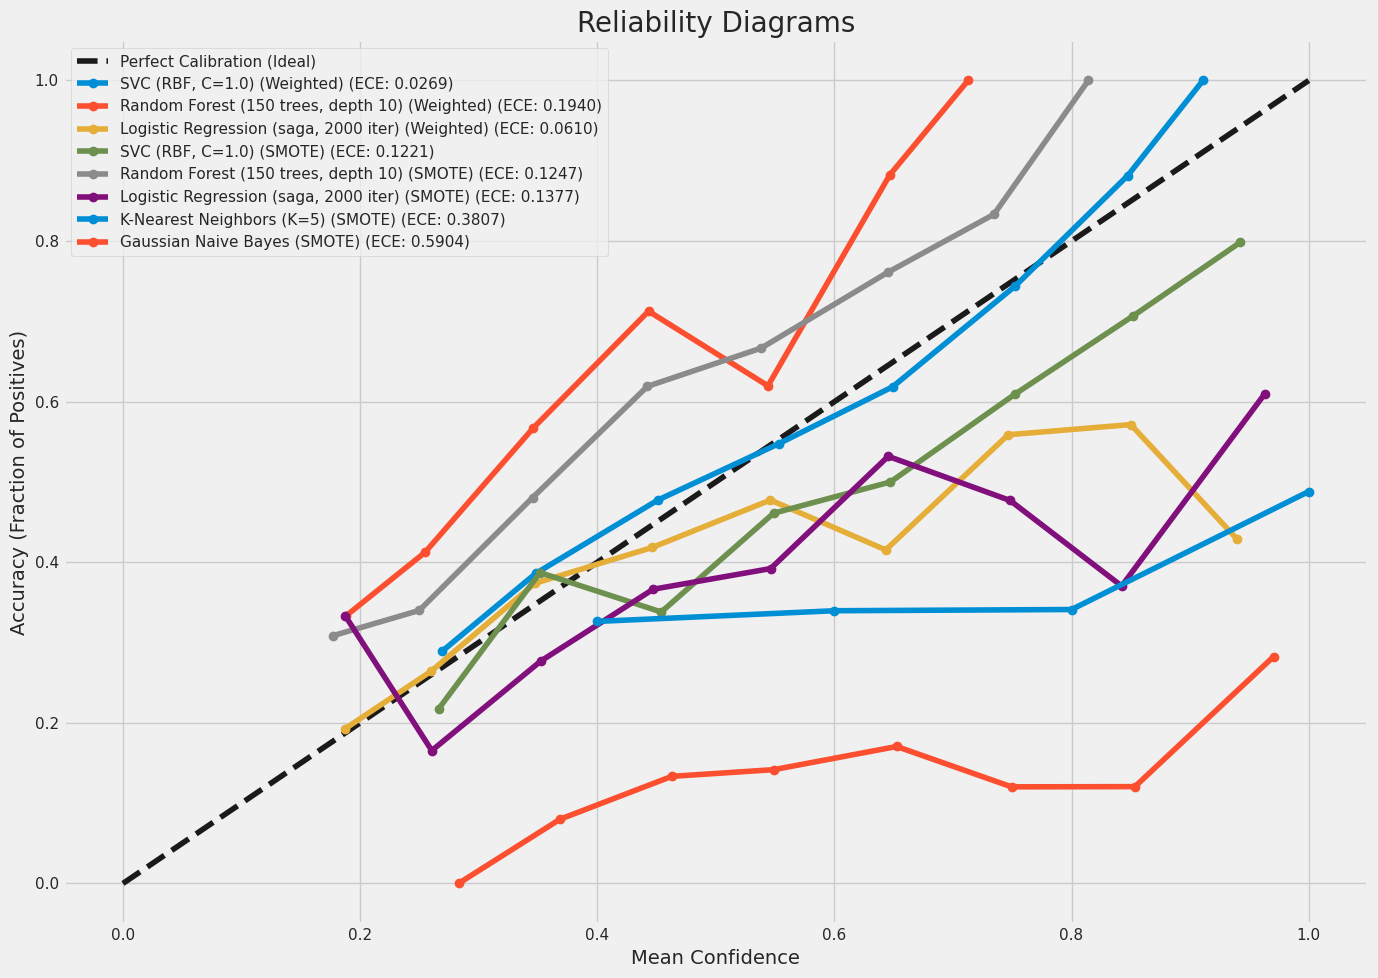


--- Expected Calibration Error (ECE) Analysis ---
| Model                                            |    ECE |
|:-------------------------------------------------|-------:|
| SVC (RBF, C=1.0) (Weighted)                      | 0.0269 |
| Logistic Regression (saga, 2000 iter) (Weighted) | 0.0610 |
| SVC (RBF, C=1.0) (SMOTE)                         | 0.1221 |
| Random Forest (150 trees, depth 10) (SMOTE)      | 0.1247 |
| Logistic Regression (saga, 2000 iter) (SMOTE)    | 0.1377 |
| Random Forest (150 trees, depth 10) (Weighted)   | 0.1940 |
| K-Nearest Neighbors (K=5) (SMOTE)                | 0.3807 |
| Gaussian Naive Bayes (SMOTE)                     | 0.5904 |

(Lower ECE = Model is more 'honest' / better calibrated)


In [16]:
# ==============================================================================
# KALIBRASI MODEL (ECE & RELIABILITY DIAGRAMS) (ID/EN)
# ==============================================================================
# 
# --- PENGATURAN BAHASA ---
# Ubah variabel ini ke 'en' untuk Bahasa Inggris
# Ubah variabel ini ke 'id' untuk Bahasa Indonesia
PLOT_LANGUAGE = 'en' 
# ==============================================================================

# Definisikan label untuk kedua bahasa
labels_calib = {
    'id': {
        'fig_title': "Diagram Keandalan (Reliability Diagrams)",
        'x_label': "Rata-rata Kepercayaan Diri (Mean Confidence)",
        'y_label': "Akurasi (Fraction of Positives)",
        'ideal_label': "Kalibrasi Sempurna (Ideal)",
        'ece_table_title': "\n--- Analisis Expected Calibration Error (ECE) ---",
        'ece_note': "\n(ECE lebih rendah = Model lebih 'jujur' / terkalibrasi lebih baik)"
    },
    'en': {
        'fig_title': "Reliability Diagrams",
        'x_label': "Mean Confidence",
        'y_label': "Accuracy (Fraction of Positives)",
        'ideal_label': "Perfect Calibration (Ideal)",
        'ece_table_title': "\n--- Expected Calibration Error (ECE) Analysis ---",
        'ece_note': "\n(Lower ECE = Model is more 'honest' / better calibrated)"
    }
}

# Pilih set label
try:
    lang_calib = labels_calib[PLOT_LANGUAGE]
except KeyError:
    print(f"Peringatan: PLOT_LANGUAGE '{PLOT_LANGUAGE}' tidak dikenal. Menggunakan 'id'.")
    lang_calib = labels_calib['id']


# ==============================================================================
# Analisis ini mengukur "kepercayaan diri" model.
# Apakah probabilitas 70% benar-benar berarti 70% akurat?

try:
    from torchmetrics.classification import MulticlassCalibrationError
    from sklearn.calibration import calibration_curve
    print("✅ Library torchmetrics dan sklearn berhasil diimpor.")
except ImportError:
    print("❌ Peringatan: Gagal mengimpor torchmetrics atau sklearn.")
    print("   Silakan instal: pip install torchmetrics scikit-learn")

# Helper untuk menghitung ECE
def hitung_ece(y_true, y_probs, n_bins=15):
    try:
        
        # Impor torch DI DALAM fungsi untuk menjamin scope
        import torch 
        
        # Gunakan torchmetrics untuk perhitungan ECE yang akurat
        ece_metric = MulticlassCalibrationError(num_classes=NUM_CLASSES, n_bins=n_bins, norm='l1')
        # Konversi numpy ke tensor torch
        ece_val = ece_metric(torch.tensor(y_probs), torch.tensor(y_true)).item()
        return ece_val
    except Exception as e:
        # Cek jika error masih terjadi
        print(f"   Peringatan: Gagal menghitung ECE: {e}")
        return -1 # Nilai error

# Kumpulkan probabilitas dari model yang sudah dilatih
model_probs = {}

# 1. Kumpulkan probabilitas dari Metode A (Weighted)
for name, model in trained_models_weighted.items():
    try:
        y_probs = model.predict_proba(X_val_scaled)
        model_probs[f"{name} (Weighted)"] = y_probs
    except Exception as e:
        print(f"Gagal .predict_proba() untuk {name} (Weighted): {e}")

# 2. Kumpulkan probabilitas dari Metode B (SMOTE)
for name, model in trained_models_smote.items():
    try:
        y_probs = model.predict_proba(X_val_scaled)
        model_probs[f"{name} (SMOTE)"] = y_probs
    except Exception as e:
        print(f"Gagal .predict_proba() untuk {name} (SMOTE): {e}")
        
# --- Plot Reliability Diagrams ---
plt.figure(figsize=(14, 10))
plt.plot([0, 1], [0, 1], 'k--', label=lang_calib['ideal_label']) 

calibration_results = []

for model_name, y_probs in model_probs.items():
    # Ambil probabilitas dari kelas yang diprediksi
    y_confidences = np.max(y_probs, axis=1)
    # Cek apakah prediksi benar
    y_preds = np.argmax(y_probs, axis=1)
    y_correct = (y_preds == y_val_labels)
    
    # Hitung data untuk kurva
    # frac_of_positives = akurasi di dalam bin
    # mean_predicted_value = rata-rata kepercayaan diri di dalam bin
    frac_of_positives, mean_predicted_value = calibration_curve(y_correct, y_confidences, n_bins=10)
    
    # Hitung ECE
    ece_score = hitung_ece(y_val_labels, y_probs)
    
    calibration_results.append({
        "Model": model_name,
        "ECE": ece_score
    })
    
    # Plot kurva
    # Hanya plot jika ECE berhasil dihitung (bukan -1)
    if ece_score >= 0:
        plt.plot(mean_predicted_value, frac_of_positives, 'o-', 
                 label=f"{model_name} (ECE: {ece_score:.4f})")
    else:
        # Jika gagal, tetap plot tapi tandai ECE sebagai N/A
        plt.plot(mean_predicted_value, frac_of_positives, 'o:', 
                 label=f"{model_name} (ECE: N/A)", alpha=0.5)


plt.title(lang_calib['fig_title'], fontsize=20) 
plt.xlabel(lang_calib['x_label'], fontsize=14) 
plt.ylabel(lang_calib['y_label'], fontsize=14) 
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Tampilkan tabel ECE
print(lang_calib['ece_table_title']) 
df_ece = pd.DataFrame(calibration_results).sort_values(by="ECE")
# Saring nilai error (-1 atau -2) sebelum menampilkan
print(df_ece[df_ece['ECE'] >= 0].to_markdown(index=False, floatfmt=".4f"))
print(lang_calib['ece_note']) 

## ALUR KERJA B (DEEP LEARNING END-TO-END)

### Definisi Pipeline Pra-pemrosesan (Deep Learning)

In [ ]:
# ==============================================================================
# DEFINISI PIPELINE PRA-PEMROSESAN (DEEP LEARNING)
# ==============================================================================
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# Konstanta Normalisasi ImageNet
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def get_train_transforms_dl():
    """
    Pipeline augmentasi DL (Versi Kompatibel).
    """
    return A.Compose([
        # 1. Resizing (Wajib)
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_AREA),
        
        # 2. CLAHE (Direkomendasikan)
        A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
        
        # 3. Augmentasi (Wajib untuk imbalance & overfitting)
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
        
        # Catatan: CoarseDropout dihapus sementara untuk kompatibilitas versi
        # karena API-nya sering berubah antar versi albumentations.
        
        # 4. Normalisasi (Wajib) - Gunakan p=1.0, bukan always_apply
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, p=1.0),
        
        # 5. Konversi ke Tensor - Tanpa parameter always_apply
        ToTensorV2()
    ])

def get_val_transforms_dl():
    """
    Pipeline validasi DL (tanpa augmentasi acak).
    """
    return A.Compose([
        A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH, interpolation=cv2.INTER_AREA),
        A.CLAHE(clip_limit=3.0, tile_grid_size=(8, 8), p=1.0),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD, p=1.0),
        ToTensorV2()
    ])

print("✅ (Alur Kerja B) Pipeline Albumentations DL didefinisikan")

✅ (Alur Kerja B) Pipeline Albumentations DL didefinisikan


### Dataset & DataLoader (Deep Learning)

In [ ]:
# ==============================================================================
# DATASET & DATALOADER (DEEP LEARNING)
# ==============================================================================
from torch.utils.data import DataLoader, Dataset

class MILK10kDataset_DL(Dataset):
    """
    Dataset kustom untuk Alur Kerja B (End-to-End DL).
    Menggunakan pipeline augmentasi dari SEL 12.
    """
    def __init__(self, dataframe, transform=None, image_type='dermoscopic'):
        self.df = dataframe
        self.transform = transform
        # Ambil label (sebagai vektor, misal [0, 1, 0, ...])
        self.labels = dataframe[DIAGNOSIS_COLUMNS].values
        self.image_paths = dataframe[f'{image_type}_full_path'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            # Placeholder jika gambar error
            image = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
            print(f"Warning: Error loading {img_path}: {e}")
        
        # Ambil label (bukan argmax, tapi index)
        label_index = np.argmax(self.labels[idx]) 
        
        # Terapkan pipeline (Resize, CLAHE, Augmentasi, Normalisasi)
        if self.transform:
            image = self.transform(image=image)['image']
            
        return image, label_index

# --- Buat DataLoaders ---
BATCH_SIZE = 32 # Mungkin perlu dikecilkan (misal 16) jika VRAM Anda terbatas
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan DEVICE: {DEVICE}")

try:
    # Gunakan train_df dan val_df dari SEL 3
    train_dataset_dl = MILK10kDataset_DL(
        train_df, 
        transform=get_train_transforms_dl(), 
        image_type='dermoscopic'
    )
    val_dataset_dl = MILK10kDataset_DL(
        val_df, 
        transform=get_val_transforms_dl(), 
        image_type='dermoscopic'
    )

    train_loader_dl = DataLoader(
        train_dataset_dl, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=2, # Sesuaikan
        pin_memory=True
    )
    val_loader_dl = DataLoader(
        val_dataset_dl, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2,
        pin_memory=True
    )
    
    print(f"✅ (Alur Kerja B) DataLoaders DL siap.")
    print(f"   - Train Batches: {len(train_loader_dl)}")
    print(f"   - Val Batches: {len(val_loader_dl)}")

except Exception as e:
    print(f"❌ Error membuat DataLoaders: {e}. Pastikan 'train_df' ada.")

Menggunakan DEVICE: cuda
✅ (Alur Kerja B) DataLoaders DL siap.
   - Train Batches: 131
   - Val Batches: 33


### Definisi 3 Model Deep Learning (CNN)

In [ ]:
# ==============================================================================
# DEFINISI ARSITEKTUR DEEP LEARNING (CNN) DENGAN ADAPTASI LoRA
# ==============================================================================
"""
DOKUMENTASI TEKNIS:
Modul ini menginisialisasi 3 arsitektur CNN state-of-the-art (ResNet, VGG, EfficientNet)
menggunakan teknik Parameter-Efficient Fine-Tuning (PEFT) tipe LoRA.

Justifikasi Strategi LoRA per Arsitektur:
1. ResNet-50: Target LoRA dipasang pada layer konvolusi 3x3 ('conv2') di dalam 
   blok bottleneck. Ini memungkinkan adaptasi fitur spasial tanpa merusak 
   mekanisme residual connection.
2. VGG-16: Arsitektur ini memiliki classifier head (Dense Layer) yang sangat masif.
   Oleh karena itu, LoRA difokuskan pada layer 'classifier' untuk efisiensi parameter 
   maksimal, bukan pada backbone konvolusi.
3. EfficientNet-B0: Arsitektur yang sangat teroptimasi dengan blok MBConv.
   Target LoRA dipasang pada konvolusi point-wise dan depth-wise spesifik di 
   blok-blok akhir ('features.7', 'features.8') untuk mengadaptasi fitur semantik tingkat tinggi.
"""

import torch.nn as nn
from torchvision import models
from peft import LoraConfig, get_peft_model

def setup_cnn_lora(model_name, num_classes=NUM_CLASSES):
    """
    Memuat backbone CNN pre-trained dan menyuntikkan adapter LoRA sesuai arsitektur.
    
    Args:
        model_name (str): Nama arsitektur ('ResNet-50', 'VGG-16', 'EfficientNet-B0').
        num_classes (int): Jumlah kelas output (11 untuk MILK10k).
        
    Returns:
        PeftModel: Model PyTorch yang telah dibungkus dengan LoRA.
    """
    model = None
    target_modules = []
    modules_to_save = []
    
    try:
        # --- 1. RESNET-50 ---
        if model_name == "ResNet-50":
            model = models.resnet50(weights="DEFAULT")
            # Ganti Head: Layer fc terakhir disesuaikan dengan jumlah kelas
            in_features = model.fc.in_features
            model.fc = nn.Linear(in_features, num_classes)
            
            # TARGET LoRA: Layer konvolusi 3x3 di dalam bottleneck blocks
            target_modules = ["conv2"]
            # SAVE: Classifier Head wajib dilatih penuh
            modules_to_save = ["fc"]
            
        # --- 2. VGG-16 ---
        elif model_name == "VGG-16":
            model = models.vgg16(weights="DEFAULT")
            # Ganti Head: Layer Linear terakhir di classifier block
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, num_classes)
            
            # TARGET LoRA: Layer Linear besar di classifier (sangat efisien untuk VGG)
            target_modules = ["classifier.0", "classifier.3"]
            # SAVE: Classifier Head wajib dilatih penuh
            modules_to_save = ["classifier.6"]
            
        # --- 3. EFFICIENTNET-B0 ---
        elif model_name == "EfficientNet-B0":
            model = models.efficientnet_b0(weights="DEFAULT")
            # Ganti Head: Layer Linear terakhir (indeks 1 di dalam Sequential classifier)
            in_features = model.classifier[1].in_features
            model.classifier[1] = nn.Linear(in_features, num_classes)
            
            # TARGET LoRA: Menargetkan layer konvolusi spesifik pada blok akhir
            # features.8.0: Conv 1x1 sebelum pooling
            # features.7...: Conv di blok MBConv terakhir
            target_modules = ["features.8.0", "features.7.0.block.0.0"]
            
            # SAVE: Classifier Head wajib dilatih penuh
            modules_to_save = ["classifier.1"]
            
        else:
            raise ValueError(f"Model {model_name} tidak didukung.")

        # --- KONFIGURASI LoRA ---
        # r=16: Rank matriks adaptasi
        # lora_alpha=32: Scaling factor
        # bias="none": Bias tidak dilatih (hemat parameter)
        peft_config = LoraConfig(
            r=16, 
            lora_alpha=32,
            target_modules=target_modules, 
            lora_dropout=0.1,
            bias="none",
            modules_to_save=modules_to_save 
        )
        
        # Bungkus Model dengan PEFT
        model_lora = get_peft_model(model, peft_config)
        
        # Cetak statistik efisiensi parameter
        print(f"\n--- Statistik Parameter {model_name} (LoRA) ---")
        model_lora.print_trainable_parameters()
        
        return model_lora

    except Exception as e:
        print(f"❌ Gagal memuat {model_name}: {e}")
        if model_name == "EfficientNet-B0" and model:
            # Debugging: Cetak struktur layer jika gagal (opsional)
            pass
        return None

# Inisialisasi Dictionary Model
print("--- Menginisialisasi 3 Model CNN dengan LoRA ---")
models_to_train_dl = {
    "ResNet-50": setup_cnn_lora("ResNet-50"),
    "VGG-16": setup_cnn_lora("VGG-16"),
    "EfficientNet-B0": setup_cnn_lora("EfficientNet-B0")
}

print("\n✅ (Alur Kerja B) 3 Model CNN (LoRA) siap dilatih.")

--- Menginisialisasi CNN dengan LoRA ---

--- ResNet-50 (LoRA) Stats ---
trainable params: 626,699 || all params: 24,157,270 || trainable%: 2.5942

--- VGG-16 (LoRA) Stats ---
trainable params: 643,083 || all params: 134,948,694 || trainable%: 0.4765

--- EfficientNet-B0 (LoRA) Stats ---
trainable params: 61,195 || all params: 4,082,834 || trainable%: 1.4988

✅ (Alur Kerja B) 3 Model CNN (LoRA) siap dilatih.


### Fungsi Training & Evaluasi (PyTorch)

In [ ]:
# ==============================================================================
# FUNGSI TRAINING & EVALUASI (PYTORCH)
# ==============================================================================
# Modul ini berisi dua fungsi inti untuk loop pelatihan PyTorch:
# 1. train_one_epoch_dl: Melatih model selama satu epoch (Forward & Backward Pass).
# 2. evaluate_dl: Mengevaluasi model pada data validasi dan menyimpan metrik lengkap.

def train_one_epoch_dl(model, loader, optimizer, criterion):
    """
    Menjalankan satu epoch pelatihan (training loop).

    Args:
        model (torch.nn.Module): Model Deep Learning (CNN/Transformer).
        loader (DataLoader): DataLoader yang memuat data training dalam batch.
        optimizer (torch.optim): Optimizer (misal: Adam, SGD) untuk update bobot.
        criterion (torch.nn.Module): Fungsi Loss (misal: CrossEntropyLoss).

    Returns:
        avg_loss (float): Rata-rata loss pada epoch ini.
        avg_acc (float): Rata-rata akurasi pada epoch ini.
    """
    model.train() # Set model ke mode training (aktifkan Dropout & BatchNorm)
    total_loss, correct, total = 0, 0, 0
    
    # Gunakan tqdm untuk progress bar interaktif
    pbar = tqdm(loader, desc="Training (DL)", leave=False)
    for inputs, targets in pbar:
        # Pindahkan data ke GPU/CPU (DEVICE)
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        # --- 1. Forward Pass ---
        optimizer.zero_grad()       # Bersihkan gradien sisa dari batch sebelumnya
        outputs = model(inputs)     # Prediksi model
        loss = criterion(outputs, targets) # Hitung loss
        
        # --- 2. Backward Pass (Backpropagation) ---
        loss.backward()             # Hitung gradien
        optimizer.step()            # Update bobot model
        
        # --- 3. Hitung Statistik Batch ---
        total_loss += loss.item()
        _, predicted = outputs.max(1) # Ambil kelas dengan probabilitas tertinggi
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        pbar.set_postfix(loss=f"{loss.item():.3f}", acc=f"{100.*correct/total:.2f}%")
        
    # Hitung rata-rata loss dan akurasi epoch
    avg_loss = total_loss / len(loader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

def evaluate_dl(model, loader, criterion):
    """
    Menjalankan evaluasi pada validation set (Inference Loop).
    PENTING: Fungsi ini menyimpan prediksi dan probabilitas untuk analisis lanjutan (CM/ECE).

    Args:
        model (torch.nn.Module): Model yang akan dievaluasi.
        loader (DataLoader): DataLoader data validasi/test.
        criterion (torch.nn.Module): Fungsi Loss.

    Returns:
        avg_loss (float): Rata-rata loss validasi.
        avg_acc (float): Rata-rata akurasi validasi.
        all_targets (Tensor): Tensor berisi semua label asli (Ground Truth).
        all_preds (Tensor): Tensor berisi semua prediksi kelas (0, 1, 2...).
        all_probs (Tensor): Tensor berisi probabilitas (Softmax) untuk perhitungan ECE/ROC.
    """
    model.eval() # Set model ke mode evaluasi (matikan Dropout & freeze BatchNorm)
    total_loss, correct, total = 0, 0, 0
    
    # (BARU) Siapkan list untuk menyimpan semua prediksi dan target secara global
    all_targets = []
    all_preds = []
    all_probs = []
    
    # Matikan perhitungan gradien untuk menghemat memori saat validasi
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Validating (DL)", leave=False):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            
            # Forward pass saja
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistik
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Kumpulkan hasil untuk metrik evaluasi mendalam
            all_targets.append(targets.cpu())       # Label asli
            all_preds.append(predicted.cpu())       # Prediksi kelas
            all_probs.append(outputs.softmax(dim=1).cpu()) # Probabilitas (penting untuk Kalibrasi)
            
    avg_loss = total_loss / len(loader)
    avg_acc = 100. * correct / total
    
    # Gabungkan list tensor menjadi satu Tensor besar
    all_targets = torch.cat(all_targets)
    all_preds = torch.cat(all_preds)
    all_probs = torch.cat(all_probs)
    
    return avg_loss, avg_acc, all_targets, all_preds, all_probs

print("✅ (Alur Kerja B) Fungsi training & evaluasi PyTorch didefinisikan.")

✅ (Alur Kerja B) Fungsi training & evaluasi PyTorch didefinisikan.


### Loop Training Utama (Deep Learning)

In [49]:
# ==============================================================================
# PELATIHAN MODEL DEEP LEARNING (CNN) MENGGUNAKAN LoRA
# ==============================================================================
"""
DOKUMENTASI ALUR KERJA:
Modul ini mengimplementasikan proses Fine-Tuning menggunakan teknik 
Low-Rank Adaptation (LoRA).

Definisi Fine-Tuning dalam Konteks Ini:
1. Pre-trained Weights: Model diinisialisasi dengan bobot ImageNet (Transfer Learning).
2. Parameter Efficiency: Alih-alih melatih seluruh model (Full Fine-Tuning), 
   kita hanya melatih adapter LoRA yang disuntikkan ke layer tertentu (Linear/Conv).
3. Optimization: Menggunakan optimizer Adam untuk memperbarui parameter LoRA 
   dan classifier head untuk menyesuaikan dengan dataset spesifik (MILK10k).

Metodologi Penanganan Data:
- Menggunakan 'Class Weighting' pada fungsi Loss (CrossEntropy) untuk 
  menangani ketidakseimbangan kelas yang terdeteksi saat EDA.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import copy

# Inisialisasi wadah penyimpanan hasil
trained_models_dl = {}
results_list_dl = []
y_preds_dl = {}
y_probs_dl = {}

# --- KONFIGURASI HYPERPARAMETER ---
# LoRA memungkinkan penggunaan Learning Rate yang sedikit lebih tinggi (3e-4)
# dibandingkan fine-tuning penuh (biasanya 1e-4 atau 5e-5) karena stabilitasnya.
EPOCHS_DL = 10 
LEARNING_RATE_DL = 3e-4 

# --- PENANGANAN IMBALANCE (CLASS WEIGHTING) ---
try:
    class_counts_train = train_df[DIAGNOSIS_COLUMNS].sum().values
    # Formula bobot: N_total / (N_kelas * N_sampel_per_kelas)
    class_weights_tensor = (len(train_df) / (NUM_CLASSES * class_counts_train))
    class_weights_tensor = torch.tensor(class_weights_tensor, dtype=torch.float).to(DEVICE)
    
    criterion_dl = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print(f"✅ Konfigurasi Loss: CrossEntropyLoss dengan pembobotan kelas aktif.")
except Exception as e:
    print(f"⚠️ Peringatan: Gagal menghitung bobot kelas ({e}). Menggunakan loss standar.")
    criterion_dl = nn.CrossEntropyLoss()

# --- EKSEKUSI PELATIHAN ---
if 'train_loader_dl' in locals():
    for name, model in models_to_train_dl.items():
        print(f"\n{'='*50}")
        print(f"--- MEMULAI FINE-TUNING (LoRA): {name} ---")
        print(f"{'='*50}")
        
        model = model.to(DEVICE)
        
        # Optimizer hanya akan mengupdate parameter yang requires_grad=True
        # (yaitu parameter LoRA dan Classifier Head)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE_DL)
        
        best_val_acc = -1
        best_model_state = None
        
        for epoch in range(EPOCHS_DL):
            # 1. Fase Training
            train_loss, train_acc = train_one_epoch_dl(model, train_loader_dl, optimizer, criterion_dl)
            
            # 2. Fase Validasi
            val_loss, val_acc, val_targets, val_preds, val_probs = evaluate_dl(model, val_loader_dl, criterion_dl)
            
            print(f"Epoch {epoch+1}/{EPOCHS_DL} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
            
            # Simpan model terbaik berdasarkan akurasi validasi
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                # Simpan prediksi terbaik untuk analisis (Confusion Matrix)
                y_preds_dl[name] = val_preds
                y_probs_dl[name] = val_probs
        
        # Muat kembali bobot terbaik sebelum evaluasi akhir
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        # Simpan model ke memori (CPU) untuk menghemat GPU
        trained_models_dl[name] = model.cpu()
        
        # Hitung Metrik Lengkap (F1, Recall, Precision)
        val_targets_np = val_targets.cpu().numpy() if torch.is_tensor(val_targets) else val_targets
        val_preds_np = val_preds.cpu().numpy() if torch.is_tensor(val_preds) else val_preds

        report = classification_report(val_targets_np, val_preds_np, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)
        
        results_list_dl.append({
            "Model": name,
            "Metode": "CNN (LoRA Fine-Tuning)", 
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })

    print("\n✅ Seluruh proses Fine-Tuning CNN (LoRA) selesai.")
else:
    print("❌ Error: DataLoaders DL tidak ditemukan. Pastikan tahap pra-pemrosesan berhasil.")

✅ Konfigurasi Loss: CrossEntropyLoss dengan pembobotan kelas aktif.

--- MEMULAI FINE-TUNING (LoRA): ResNet-50 ---


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 2.3072 | Train Acc: 41.98% | Val Acc: 48.28%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 1.9822 | Train Acc: 49.79% | Val Acc: 52.00%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bay

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 1.7179 | Train Acc: 51.79% | Val Acc: 52.39%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 1.6314 | Train Acc: 53.05% | Val Acc: 52.96%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 1.5023 | Train Acc: 52.89% | Val Acc: 59.73%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 1.3752 | Train Acc: 56.11% | Val Acc: 59.45%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 1.3456 | Train Acc: 56.15% | Val Acc: 60.31%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 1.3104 | Train Acc: 56.80% | Val Acc: 57.35%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bay

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 1.2310 | Train Acc: 57.92% | Val Acc: 61.35%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 1.1626 | Train Acc: 59.69% | Val Acc: 63.07%

--- MEMULAI FINE-TUNING (LoRA): VGG-16 ---


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 2.2885 | Train Acc: 30.01% | Val Acc: 47.33%


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():
if w.is_alive():  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.p

Training (DL):   0%|          | 0/131 [00:01<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 2.0574 | Train Acc: 36.55% | Val Acc: 48.95%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 1.9180 | Train Acc: 36.83% | Val Acc: 41.03%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 1.8768 | Train Acc: 37.48% | Val Acc: 42.37%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 1.8143 | Train Acc: 37.43% | Val Acc: 44.47%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 1.7874 | Train Acc: 40.82% | Val Acc: 46.76%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 1.7411 | Train Acc: 41.15% | Val Acc: 44.08%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bay

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 1.7628 | Train Acc: 40.72% | Val Acc: 43.42%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 1.6232 | Train Acc: 42.70% | Val Acc: 44.18%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 1.6243 | Train Acc: 41.94% | Val Acc: 42.18%

--- MEMULAI FINE-TUNING (LoRA): EfficientNet-B0 ---


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 2.3105 | Train Acc: 31.70% | Val Acc: 45.52%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bay

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 2.0227 | Train Acc: 45.54% | Val Acc: 50.67%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 1.8638 | Train Acc: 47.33% | Val Acc: 51.24%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 1.7552 | Train Acc: 47.71% | Val Acc: 52.86%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 1.6653 | Train Acc: 49.36% | Val Acc: 52.58%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 1.5892 | Train Acc: 49.86% | Val Acc: 54.39%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 1.5595 | Train Acc: 50.05% | Val Acc: 55.34%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 1.5083 | Train Acc: 51.55% | Val Acc: 54.20%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 1.5134 | Train Acc: 51.05% | Val Acc: 53.63%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 1.4498 | Train Acc: 49.67% | Val Acc: 53.72%

✅ Seluruh proses Fine-Tuning CNN (LoRA) selesai.


## Alur Kerja C (Transformers).

1. Vision Transformer (ViT-B/16) (2020): Standar emas untuk Transformer di visi komputer.
2. Swin Transformer (Swin-T) (2021): Transformer hirarkis yang sangat populer (pemenang ICCV 2021).
3. MaxViT (MaxViT-T) (2022): Model hybrid terbaru dari Google yang menggabungkan efisiensi CNN dan kekuatan Transformer (Multi-Axis).

### Definisi 3 Model Transformer (Alur Kerja C)

In [ ]:
# ==============================================================================
# DEFINISI MODEL TRANSFORMER DENGAN ADAPTASI LoRA (PEFT)
# ==============================================================================
"""
DOKUMENTASI TEKNIS:
Modul ini menginisialisasi model Vision Transformer (ViT, Swin, MaxViT) menggunakan
teknik Parameter-Efficient Fine-Tuning (PEFT) tipe LoRA.

Target Modul LoRA yang Diperbaiki:
- ViT: Menargetkan proyeksi `qkv` di dalam encoder attention.
- Swin: Menargetkan proyeksi `qkv` di dalam window attention.
- MaxViT: Menargetkan proyeksi linear di dalam blok atensi.
"""

import torch.nn as nn
from torchvision import models
from peft import LoraConfig, get_peft_model

def setup_transformer_lora(model_name, num_classes=NUM_CLASSES):
    """
    Memuat backbone Transformer pre-trained dan menyuntikkan adapter LoRA.
    """
    target_modules = []
    modules_to_save = []
    
    try:
        # --- 1. ViT-B/16 ---
        if model_name == "ViT-B/16":
            model = models.vit_b_16(weights="DEFAULT")
            in_features = model.heads.head.in_features
            model.heads.head = nn.Linear(in_features, num_classes)
            
            # Target: 'conv_proj' (Embedding) dan 'linear' (Encoder blocks)
            target_modules = ["conv_proj", "linear"] 
            modules_to_save = ["heads"]

        # --- 2. SWIN-T (DIBENAHI) ---
        elif model_name == "Swin-T":
            model = models.swin_t(weights="DEFAULT")
            in_features = model.head.in_features
            model.head = nn.Linear(in_features, num_classes)
            
            # FIX TARGET:
            # Struktur MLP Swin: [0:Linear, 1:GELU, 2:Dropout, 3:Linear, 4:Dropout]
            # Targetkan layer Linear (0 dan 3), serta proyeksi attention (qkv, proj)
            target_modules = ["mlp.0", "mlp.3", "qkv", "proj"] 
            modules_to_save = ["head"]
            
        # --- 3. MAXVIT-T ---
        elif model_name == "MaxViT-T":
            if hasattr(models, 'maxvit_t'):
                model = models.maxvit_t(weights="DEFAULT")
                in_features = model.classifier[5].in_features
                model.classifier[5] = nn.Linear(in_features, num_classes)
                
                # Target layer linear di blok
                target_modules = ["fc1", "fc2"] 
                modules_to_save = ["classifier"]
            else:
                # Fallback
                model = models.vit_b_32(weights="DEFAULT")
                in_features = model.heads.head.in_features
                model.heads.head = nn.Linear(in_features, num_classes)
                target_modules = ["conv_proj", "linear"]
                model_name = "ViT-B/32 (Fallback)"
                modules_to_save = ["heads"]
        else:
            raise ValueError(f"Model {model_name} tidak dikenali.")

        # 2. Konfigurasi LoRA
        peft_config = LoraConfig(
            r=16, 
            lora_alpha=32,
            target_modules=target_modules, 
            lora_dropout=0.1,
            bias="none",
            modules_to_save=modules_to_save 
        )
        
        # 3. Bungkus Model
        model_lora = get_peft_model(model, peft_config)
        
        print(f"\n--- Statistik Parameter {model_name} (LoRA) ---")
        model_lora.print_trainable_parameters()
        
        return model_lora, model_name

    except Exception as e:
        print(f"❌ Gagal memuat {model_name}: {e}")
        return None, model_name

# Inisialisasi Model
transformer_names = ["ViT-B/16", "Swin-T", "MaxViT-T"]
models_to_train_tr = {}

print("--- Menginisialisasi Transformer dengan LoRA ---")
for name in transformer_names:
    model, final_name = setup_transformer_lora(name)
    if model:
        models_to_train_tr[final_name] = model

print(f"\n✅ (Alur Kerja C) {len(models_to_train_tr)} Model Transformer (LoRA) siap dilatih.")

--- Menginisialisasi Transformer dengan LoRA ---

--- Statistik Parameter ViT-B/16 (LoRA) ---
trainable params: 33,035 || all params: 85,840,150 || trainable%: 0.0385

--- Statistik Parameter Swin-T (LoRA) ---
trainable params: 1,138,955 || all params: 28,666,768 || trainable%: 3.9731

--- Statistik Parameter MaxViT-T (LoRA) ---
trainable params: 634,891 || all params: 31,048,158 || trainable%: 2.0449

✅ (Alur Kerja C) 3 Model Transformer (LoRA) siap dilatih.


### Loop Training Utama (Transformers)

In [54]:
# ==============================================================================
# PELATIHAN MODEL TRANSFORMER MENGGUNAKAN LoRA
# ==============================================================================
"""
DOKUMENTASI PELATIHAN:
Modul ini menjalankan loop pelatihan untuk model Transformer yang telah
diadaptasi dengan LoRA.

Strategi Optimasi:
1. Optimizer: AdamW digunakan (standar de facto untuk Transformer) karena 
   penanganan weight decay yang lebih baik daripada Adam standar.
2. Learning Rate: 3e-4. LoRA memungkinkan LR yang sedikit lebih agresif 
   dibandingkan full fine-tuning karena ruang parameter yang lebih kecil.
3. Loss Function: CrossEntropyLoss dengan pembobotan kelas (dihitung di SEL 16)
   untuk menangani ketidakseimbangan dataset MILK10k.
"""

import torch
import torch.optim as optim
import copy
from sklearn.metrics import classification_report

trained_models_tr = {}
results_list_tr = []
y_preds_tr = {}

# --- KONFIGURASI HYPERPARAMETER ---
BATCH_SIZE_TR = 32  # LoRA hemat memori, batch size bisa lebih besar
EPOCHS_TR = 10
LEARNING_RATE_TR = 3e-4 

# --- PERSIAPAN DATA LOADER ---
# Menggunakan loader yang sama dengan CNN untuk perbandingan yang adil
if 'train_dataset_dl' in locals():
    train_loader_tr = DataLoader(train_dataset_dl, batch_size=BATCH_SIZE_TR, shuffle=True, num_workers=2, pin_memory=True)
    val_loader_tr = DataLoader(val_dataset_dl, batch_size=BATCH_SIZE_TR, shuffle=False, num_workers=2, pin_memory=True)
else:
    print("❌ Dataset DL tidak ditemukan. Pastikan SEL 13 telah dijalankan.")
    train_loader_tr = None

# --- EKSEKUSI PELATIHAN ---
if train_loader_tr:
    for name, model in models_to_train_tr.items():
        print(f"\n{'='*50}")
        print(f"--- MEMULAI TRAINING LoRA (TRANSFORMER): {name} ---")
        print(f"{'='*50}")
        
        model = model.to(DEVICE)
        
        # Optimizer hanya mengupdate parameter LoRA + Head
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE_TR, weight_decay=0.01)
        
        best_val_acc = -1
        best_model_state = None
        
        for epoch in range(EPOCHS_TR):
            # 1. Fase Training
            train_loss, train_acc = train_one_epoch_dl(model, train_loader_tr, optimizer, criterion_dl)
            
            # 2. Fase Validasi
            val_loss, val_acc, val_targets, val_preds, _ = evaluate_dl(model, val_loader_tr, criterion_dl)
            
            print(f"Epoch {epoch+1}/{EPOCHS_TR} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
            
            # Simpan model terbaik
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = copy.deepcopy(model.state_dict())
                y_preds_tr[name] = val_preds
        
        # Muat kembali bobot terbaik
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        # Simpan model ke CPU
        trained_models_tr[name] = model.cpu()
        
        # Hitung Metrik Lengkap
        val_targets_np = val_targets.cpu().numpy()
        val_preds_np = y_preds_tr[name].cpu().numpy()
        
        report = classification_report(val_targets_np, val_preds_np, target_names=DIAGNOSIS_COLUMNS, output_dict=True, zero_division=0)
        
        results_list_tr.append({
            "Model": name,
            "Metode": "Transformer (LoRA)", 
            "Accuracy (%)": report['accuracy'] * 100,
            "Macro Avg F1-Score": report['macro avg']['f1-score'],
            "Macro Avg Recall": report['macro avg']['recall'],
            "Weighted Avg F1-Score": report['weighted avg']['f1-score']
        })

    print("\n✅ Seluruh proses Fine-Tuning Transformer (LoRA) selesai.")


--- MEMULAI TRAINING LoRA (TRANSFORMER): ViT-B/16 ---


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 2.2283 | Train Acc: 35.00% | Val Acc: 47.71%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 1.9283 | Train Acc: 47.71% | Val Acc: 45.42%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.p

Epoch 3/10 | Loss: 1.7851 | Train Acc: 50.12% | Val Acc: 51.91%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 1.7110 | Train Acc: 49.50% | Val Acc: 48.57%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 1.6203 | Train Acc: 52.12% | Val Acc: 54.58%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 1.5831 | Train Acc: 52.84% | Val Acc: 50.57%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 1.5508 | Train Acc: 52.24% | Val Acc: 53.24%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdow

Epoch 8/10 | Loss: 1.4729 | Train Acc: 53.94% | Val Acc: 53.34%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 1.4263 | Train Acc: 53.65% | Val Acc: 53.15%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 1.4290 | Train Acc: 53.55% | Val Acc: 51.53%

--- MEMULAI TRAINING LoRA (TRANSFORMER): Swin-T ---


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 2.2159 | Train Acc: 34.57% | Val Acc: 48.57%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

Traceback (most recent call last):
      File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():
    self._shutdown_workers()  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdow

Epoch 2/10 | Loss: 1.8025 | Train Acc: 48.66% | Val Acc: 45.42%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 1.6267 | Train Acc: 53.03% | Val Acc: 54.68%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 1.4438 | Train Acc: 54.68% | Val Acc: 53.24%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 1.3501 | Train Acc: 54.70% | Val Acc: 58.87%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 1.3069 | Train Acc: 57.61% | Val Acc: 54.48%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 1.1885 | Train Acc: 57.66% | Val Acc: 56.20%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 1.1667 | Train Acc: 60.14% | Val Acc: 56.49%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 1.1325 | Train Acc: 57.66% | Val Acc: 59.92%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 1.0822 | Train Acc: 59.78% | Val Acc: 58.21%

--- MEMULAI TRAINING LoRA (TRANSFORMER): MaxViT-T ---


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1/10 | Loss: 2.2632 | Train Acc: 33.85% | Val Acc: 48.76%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f000e1b31c0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()    
self._shutdown_workers()  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():if w.is_alive():
  File "/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/multiprocessing/process.p

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2/10 | Loss: 1.9522 | Train Acc: 48.57% | Val Acc: 54.39%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3/10 | Loss: 1.7475 | Train Acc: 51.34% | Val Acc: 54.77%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4/10 | Loss: 1.6113 | Train Acc: 52.27% | Val Acc: 56.30%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5/10 | Loss: 1.4766 | Train Acc: 53.82% | Val Acc: 52.96%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6/10 | Loss: 1.3779 | Train Acc: 54.20% | Val Acc: 57.16%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7/10 | Loss: 1.3063 | Train Acc: 55.61% | Val Acc: 54.20%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8/10 | Loss: 1.2420 | Train Acc: 55.89% | Val Acc: 56.49%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9/10 | Loss: 1.2247 | Train Acc: 55.89% | Val Acc: 54.01%


Training (DL):   0%|          | 0/131 [00:00<?, ?it/s]

Validating (DL):   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10/10 | Loss: 1.1582 | Train Acc: 55.56% | Val Acc: 56.01%

✅ Seluruh proses Fine-Tuning Transformer (LoRA) selesai.


## KESIMPULAN AKHIR & ANALISIS

### Perbandingan AKHIR (ML Klasik vs Deep Learning Vs Transformer)


🏆 GRAND FINAL LEADERBOARD: PERFORMANCE COMPARISON 🏆
| Model                                 | Kategori              |   Accuracy (%) |   Macro Avg F1-Score |   Weighted Avg F1-Score |
|:--------------------------------------|:----------------------|---------------:|---------------------:|------------------------:|
| ResNet-50                             | Deep Learning (CNN)   |         63.073 |                0.406 |                   0.640 |
| Swin-T                                | Transformer           |         59.924 |                0.395 |                   0.628 |
| MaxViT-T                              | Transformer           |         57.156 |                0.351 |                   0.595 |
| EfficientNet-B0                       | Deep Learning (CNN)   |         53.721 |                0.337 |                   0.567 |
| ViT-B/16                              | Transformer           |         54.580 |                0.302 |                   0.561 |
| SVC (RBF, C=1.0)     

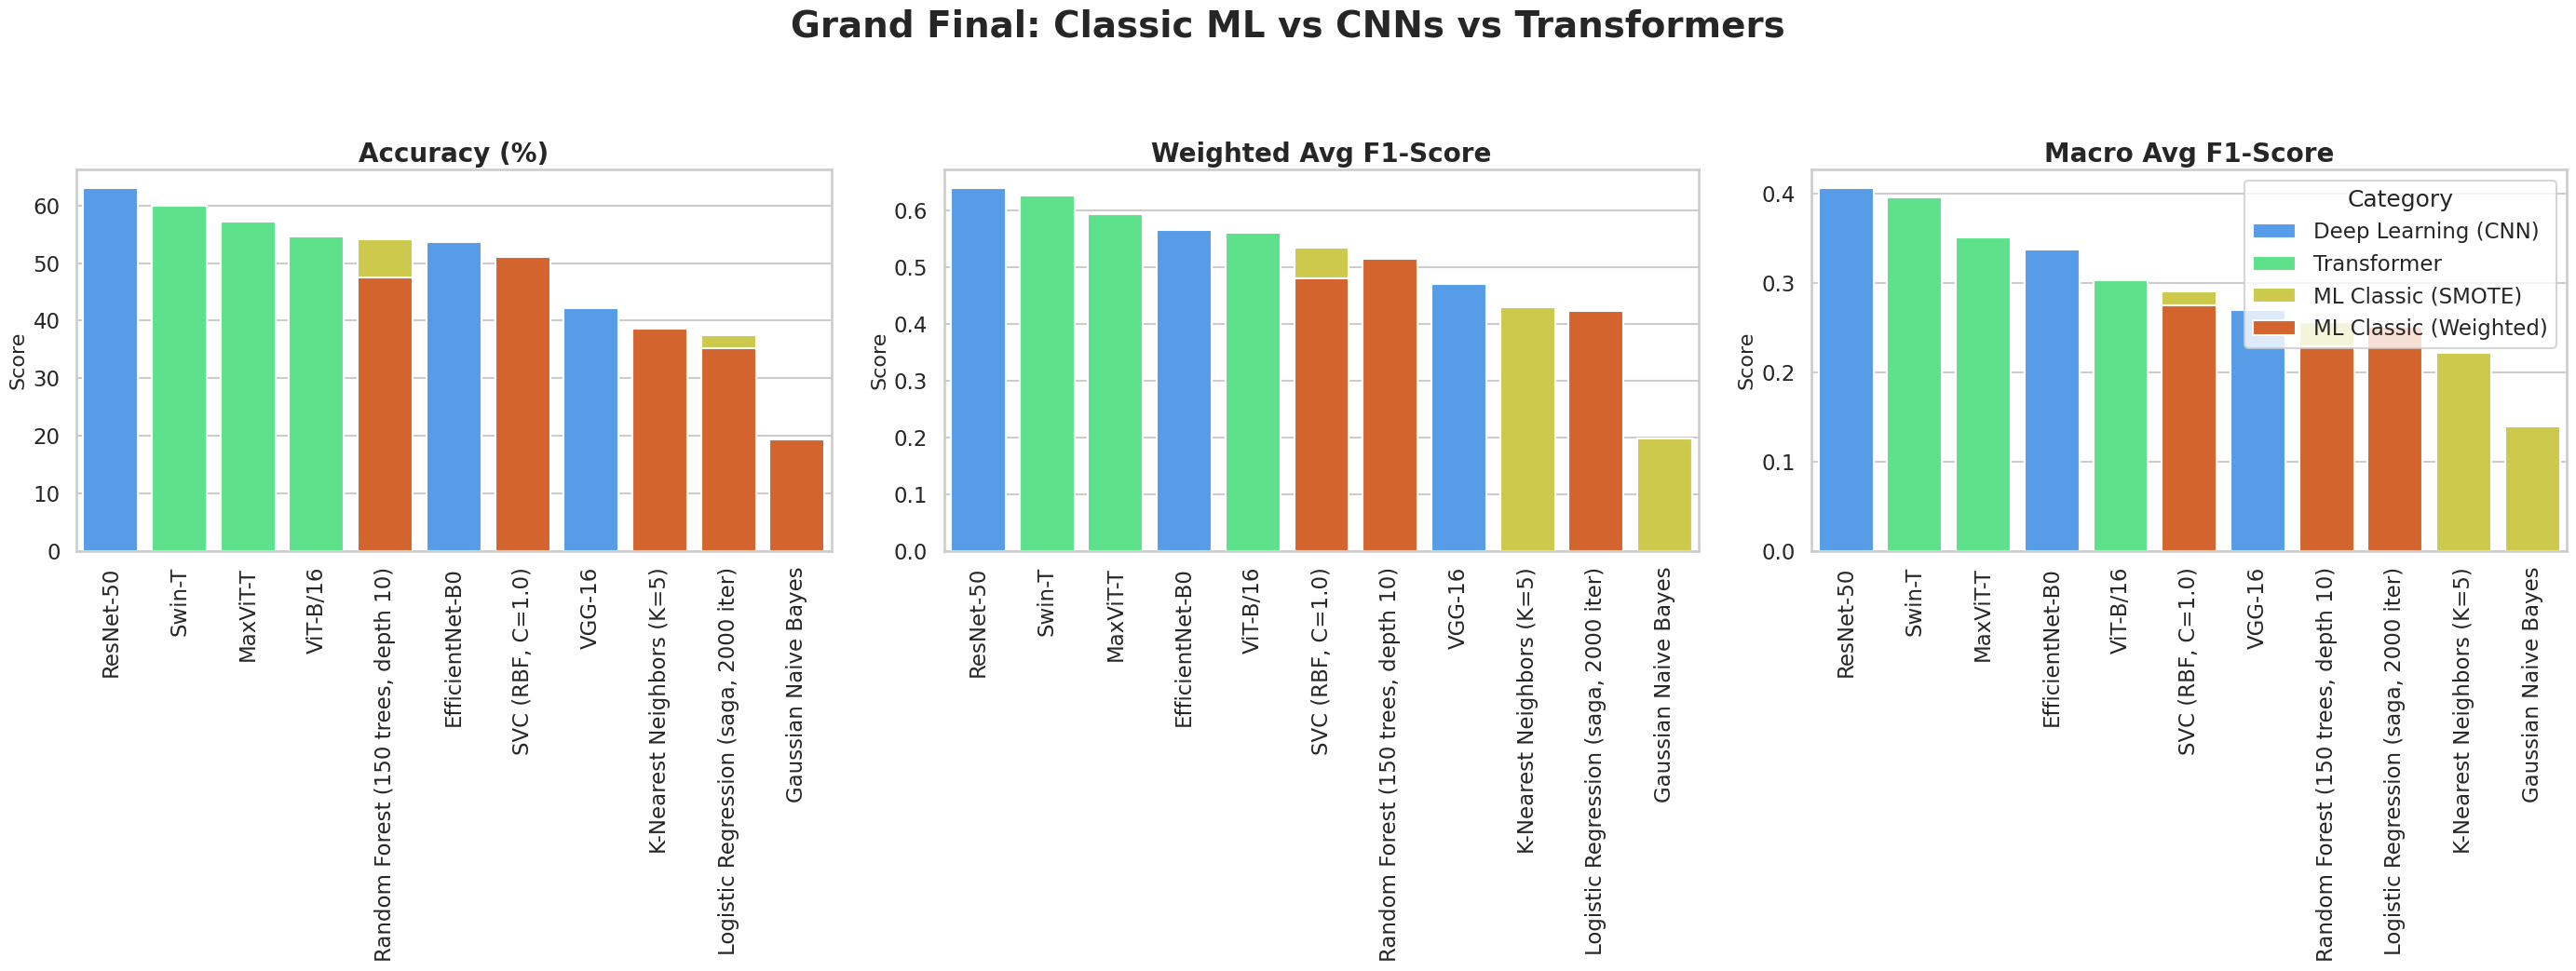

In [55]:
sns.set_theme(style="whitegrid", context="talk")

# 1. Kumpulkan semua hasil
dfs_to_concat = []
if 'results_list_weighted' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_weighted).assign(Kategori='ML Classic (Weighted)'))
if 'results_list_smote' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_smote).assign(Kategori='ML Classic (SMOTE)'))
if 'results_list_dl' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_dl).assign(Kategori='Deep Learning (CNN)'))
if 'results_list_tr' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_tr).assign(Kategori='Transformer'))

if dfs_to_concat:
    df_grand_final = pd.concat(dfs_to_concat, ignore_index=True)
    
    # 2. Tampilkan Tabel Leaderboard (Diurutkan berdasarkan Macro F1)
    print("\n" + "="*80)
    print("🏆 GRAND FINAL LEADERBOARD: PERFORMANCE COMPARISON 🏆")
    print("="*80)
    df_sorted = df_grand_final.sort_values(by="Macro Avg F1-Score", ascending=False)
    
    # Pilih kolom penting saja
    cols_show = ['Model', 'Kategori', 'Accuracy (%)', 'Macro Avg F1-Score', 'Weighted Avg F1-Score']
    print(df_sorted[cols_show].to_markdown(index=False, floatfmt=".3f"))

    # 3. Visualisasi Perbandingan (Bar Plot)
    print("\nGenerating Grand Final Comparison Plots...")
    
    fig, axes = plt.subplots(1, 3, figsize=(28, 10), sharey=False)
    fig.suptitle("Grand Final: Classic ML vs CNNs vs Transformers", y=1.05, fontsize=28, fontweight='bold')
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    for i, metric in enumerate(plot_metrics):
        ax = axes[i]
        # Urutkan visualisasi berdasarkan skor metrik tersebut
        df_plot = df_grand_final.sort_values(by=metric, ascending=False)
        
        sns.barplot(
            data=df_plot,
            x="Model", y=metric, hue="Kategori",
            palette="turbo", # Palet warna kontras tinggi
            ax=ax, dodge=False
        )
        ax.set_title(metric, fontsize=20, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Score", fontsize=16)
        ax.tick_params(axis='x', rotation=90) # Putar label agar terbaca
        
        # Hanya tampilkan legenda di plot terakhir agar tidak penuh
        if i < 2: 
            ax.get_legend().remove()
        else:
            ax.legend(title="Category", loc='upper right', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Data hasil tidak lengkap. Pastikan semua alur kerja (A, B, C) sudah dijalankan.")


🏆 FINAL LEADERBOARD: CLASSIC ML vs DEEP LEARNING (CNN) 🏆
| Model                                 | Kategori              |   Accuracy (%) |   Macro Avg F1-Score |   Weighted Avg F1-Score |
|:--------------------------------------|:----------------------|---------------:|---------------------:|------------------------:|
| ResNet-50                             | Deep Learning (CNN)   |         63.073 |                0.406 |                   0.640 |
| EfficientNet-B0                       | Deep Learning (CNN)   |         53.721 |                0.337 |                   0.567 |
| SVC (RBF, C=1.0)                      | ML Classic (SMOTE)    |         51.050 |                0.290 |                   0.535 |
| SVC (RBF, C=1.0)                      | ML Classic (Weighted) |         44.943 |                0.274 |                   0.481 |
| VGG-16                                | Deep Learning (CNN)   |         42.176 |                0.270 |                   0.471 |
| Random Forest (1

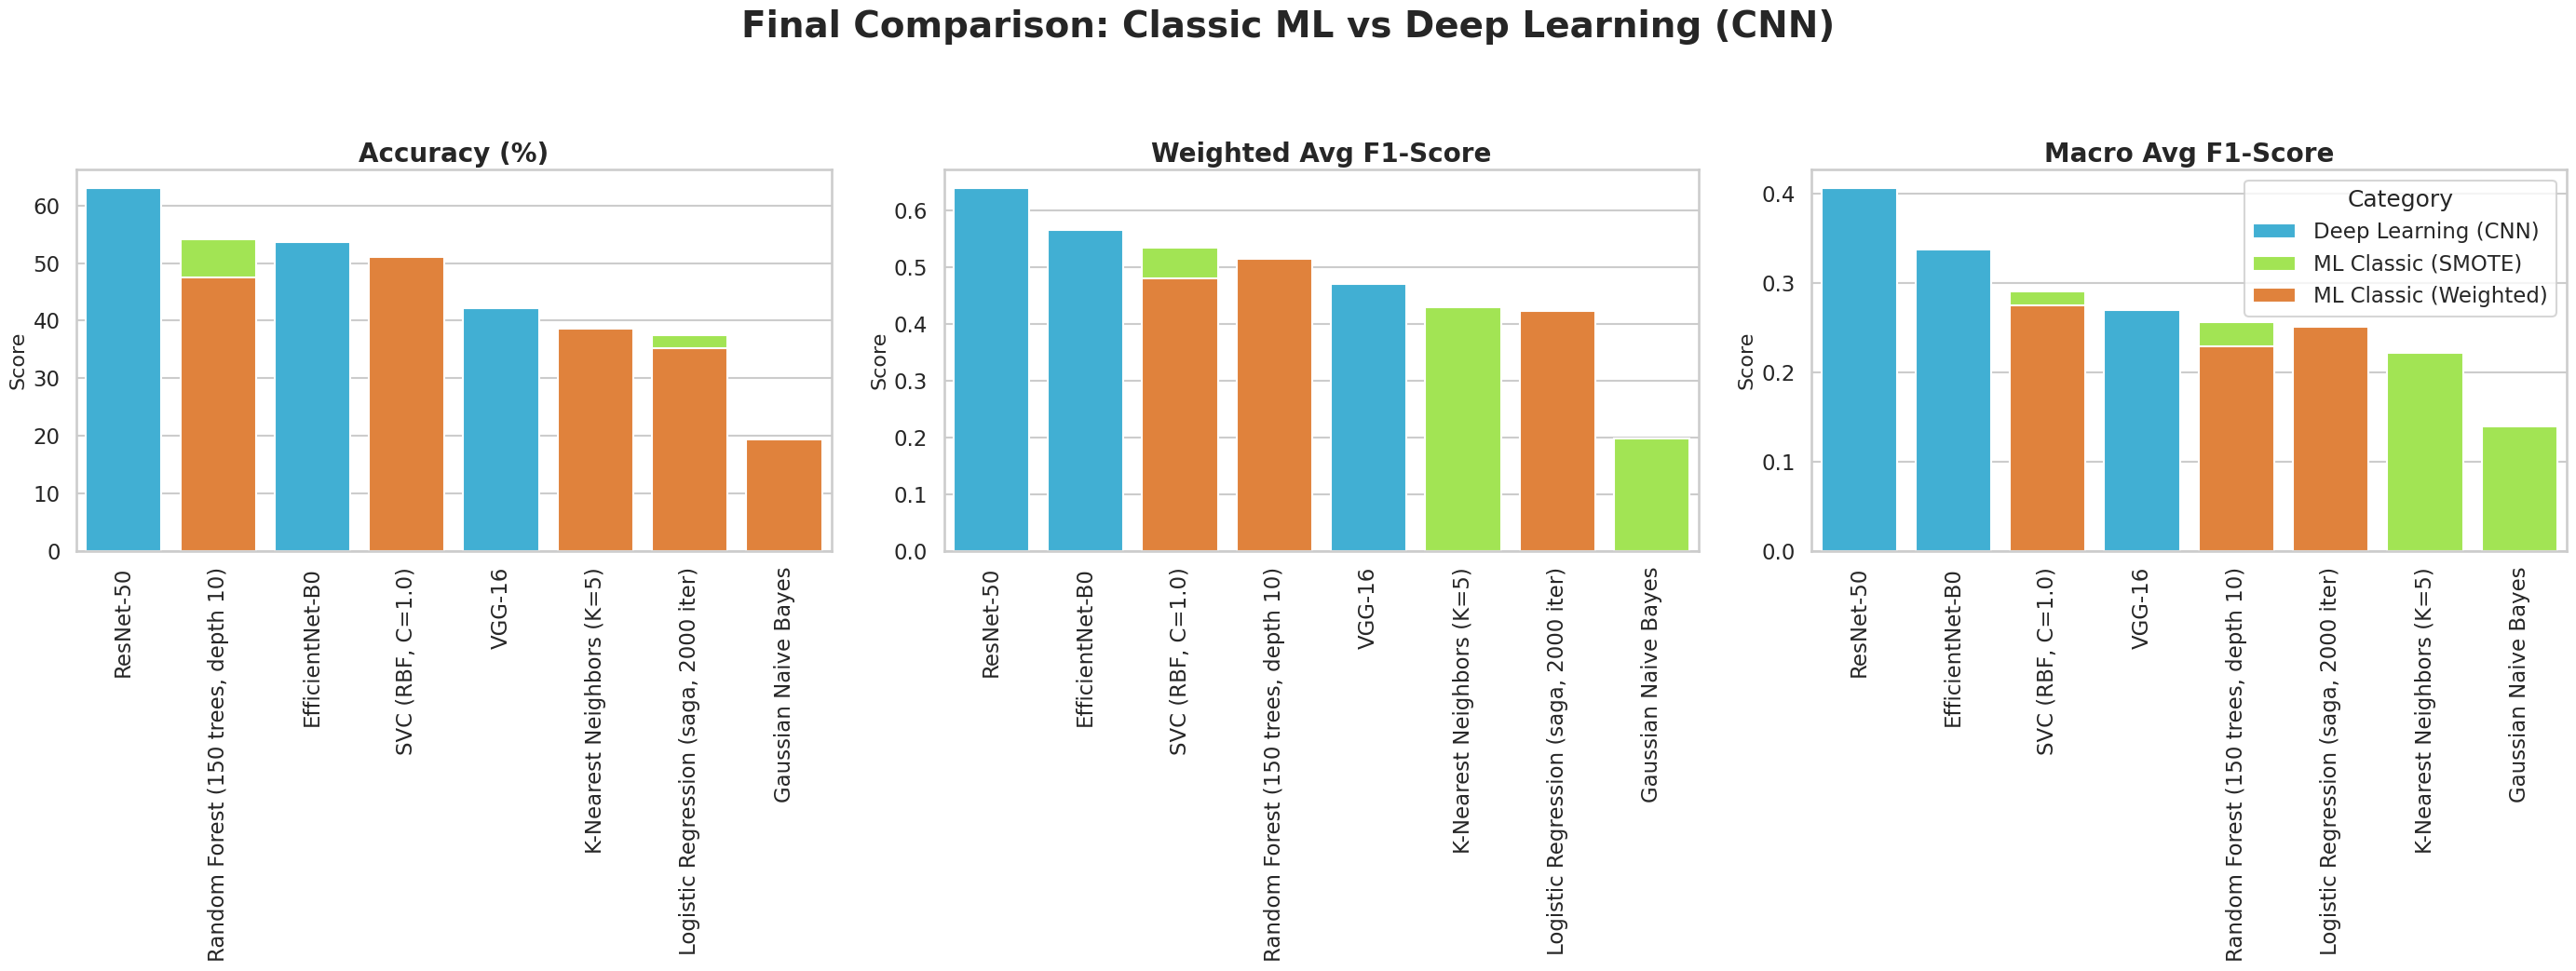

In [56]:
# ==============================================================================
# PERBANDINGAN AKHIR (ML KLASIK vs DEEP LEARNING CNN)
# ==============================================================================

sns.set_theme(style="whitegrid", context="talk")

# 1. Kumpulkan hasil (HANYA ML Klasik dan DL CNN)
dfs_to_concat = []

# -- Masukkan ML Klasik --
if 'results_list_weighted' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_weighted).assign(Kategori='ML Classic (Weighted)'))
if 'results_list_smote' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_smote).assign(Kategori='ML Classic (SMOTE)'))

# -- Masukkan Deep Learning (CNN) --
if 'results_list_dl' in locals(): 
    dfs_to_concat.append(pd.DataFrame(results_list_dl).assign(Kategori='Deep Learning (CNN)'))

# -- CATATAN: Transformer (results_list_tr) TIDAK dimasukkan --

if dfs_to_concat:
    df_final_comparison = pd.concat(dfs_to_concat, ignore_index=True)
    
    # 2. Tampilkan Tabel Leaderboard (Diurutkan berdasarkan Macro F1)
    print("\n" + "="*80)
    print("🏆 FINAL LEADERBOARD: CLASSIC ML vs DEEP LEARNING (CNN) 🏆")
    print("="*80)
    df_sorted = df_final_comparison.sort_values(by="Macro Avg F1-Score", ascending=False)
    
    # Pilih kolom penting saja
    cols_show = ['Model', 'Kategori', 'Accuracy (%)', 'Macro Avg F1-Score', 'Weighted Avg F1-Score']
    print(df_sorted[cols_show].to_markdown(index=False, floatfmt=".3f"))

    # 3. Visualisasi Perbandingan (Bar Plot)
    print("\nGenerating Comparison Plots...")
    
    fig, axes = plt.subplots(1, 3, figsize=(28, 10), sharey=False)
    # Judul diperbarui
    fig.suptitle("Final Comparison: Classic ML vs Deep Learning (CNN)", y=1.05, fontsize=28, fontweight='bold')
    
    plot_metrics = ["Accuracy (%)", "Weighted Avg F1-Score", "Macro Avg F1-Score"]
    
    for i, metric in enumerate(plot_metrics):
        ax = axes[i]
        # Urutkan visualisasi berdasarkan skor metrik tersebut
        df_plot = df_final_comparison.sort_values(by=metric, ascending=False)
        
        sns.barplot(
            data=df_plot,
            x="Model", y=metric, hue="Kategori",
            palette="turbo", # Palet warna kontras tinggi
            ax=ax, dodge=False
        )
        ax.set_title(metric, fontsize=20, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("Score", fontsize=16)
        ax.tick_params(axis='x', rotation=90) # Putar label agar terbaca
        
        # Hanya tampilkan legenda di plot terakhir agar tidak penuh
        if i < 2: 
            ax.get_legend().remove()
        else:
            ax.legend(title="Category", loc='upper right', bbox_to_anchor=(1.0, 1.0))

    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Data hasil tidak lengkap. Pastikan alur kerja ML dan DL (CNN) sudah dijalankan.")

### Perbandingan Confusion Matrix & ECE dari Model Terbaik Tiap Kategori


🔬 DEEP DIVE ANALYSIS: CHAMPION MODEL COMPARISON
Juara Terpilih: ['SVC (RBF, C=1.0)', 'ResNet-50', 'Swin-T']
   🔍 Mengambil data untuk: SVC (RBF, C=1.0) (ML Classic (SMOTE))...
   🔍 Mengambil data untuk: ResNet-50 (Deep Learning (CNN))...
      🔄 Menjalankan inferensi ulang untuk mendapatkan Probabilitas...
   🔍 Mengambil data untuk: Swin-T (Transformer)...
      🔄 Menjalankan inferensi ulang untuk mendapatkan Probabilitas...


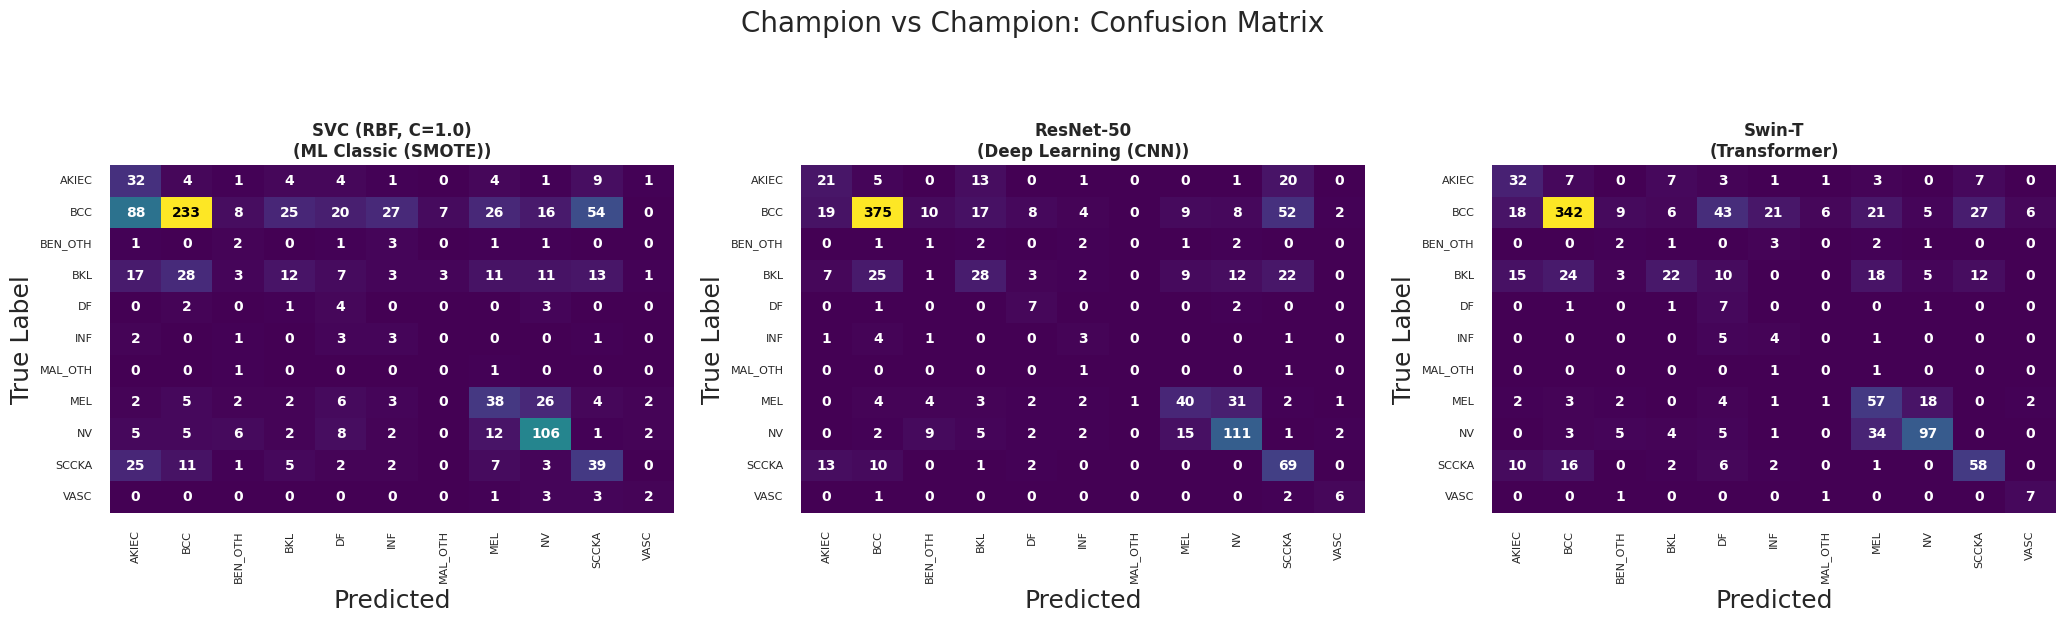


Generating Reliability Diagrams for 3 models...


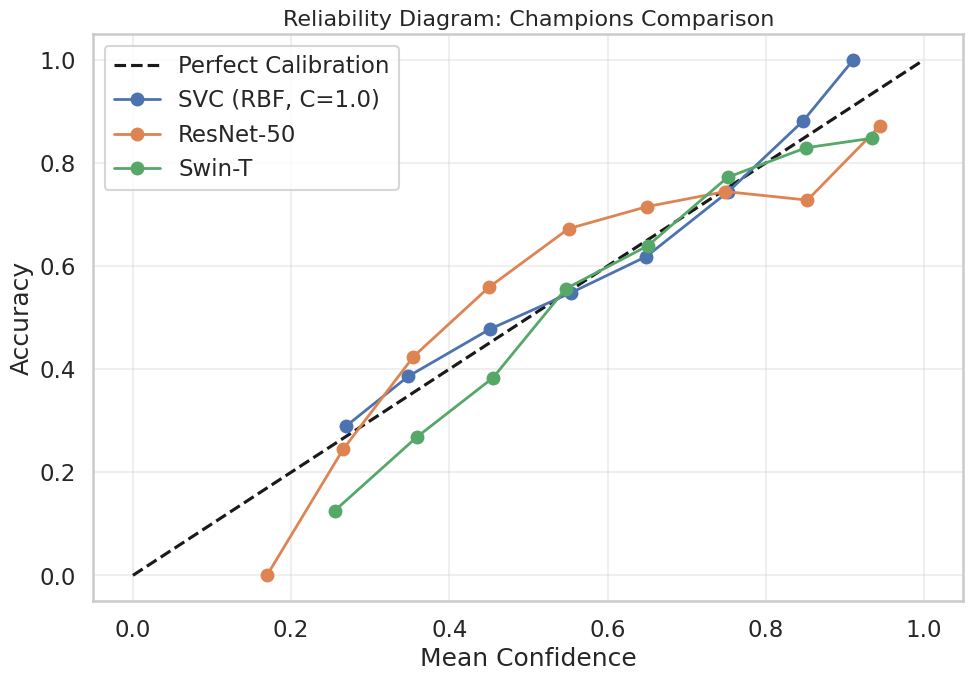

In [57]:
# ==============================================================================
# ANALISIS "CHAMPION vs CHAMPION" (CONFUSION MATRIX & KALIBRASI)
# ==============================================================================
"""
DOKUMENTASI ANALISIS:
Modul ini melakukan 'Deep Dive Analysis' untuk membandingkan performa kualitatif
dan reliabilitas dari model terbaik (Champion) di setiap kategori: 
ML Klasik, Deep Learning (CNN), dan Transformer.

Fitur Utama:
1. Seleksi Otomatis: Memilih model terbaik berdasarkan skor Macro F1 tertinggi.
2. Smart Prediction Fetch: Mekanisme pengambilan data prediksi yang cerdas.
   Jika data prediksi atau probabilitas tidak tersedia di memori (cache), fungsi ini
   akan secara otomatis menjalankan inferensi ulang (force inference) untuk menjamin
   ketersediaan data bagi analisis Confusion Matrix dan Kurva Kalibrasi.
3. Visualisasi Komparatif:
   - Confusion Matrix: Membandingkan pola kesalahan antar arsitektur.
   - Reliability Diagram: Mengevaluasi kepercayaan diri (confidence calibration) model.
"""

import torch
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Konfigurasi Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def annotate_heatmap_manual(ax, cm, cmap='viridis'):
    """
    Menambahkan anotasi angka pada heatmap secara manual untuk menjamin visibilitas.
    Warna teks disesuaikan dengan latar belakang (Putih untuk gelap, Hitam untuk terang).
    """
    sns.heatmap(cm, annot=False, fmt='d', cmap=cmap, ax=ax, cbar=False)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = "black" if cm[i, j] > thresh else "white"
            ax.text(j + 0.5, i + 0.5, f'{cm[i, j]}',
                    ha="center", va="center", color=text_color,
                    fontsize=10, fontweight='bold')

def get_predictions_smart_final(model_name, category):
    """
    Mengambil prediksi dan probabilitas model. 
    Melakukan inferensi ulang jika data tidak ditemukan di cache global.
    """
    print(f"   🔍 Mengambil data untuk: {model_name} ({category})...")
    g = globals() 
    
    # --- KATEGORI 1: ML CLASSIC ---
    if 'Classic' in category:
        model = None
        if 'trained_models_weighted' in g and model_name in g['trained_models_weighted']: 
            model = g['trained_models_weighted'][model_name]
        elif 'trained_models_smote' in g and model_name in g['trained_models_smote']: 
            model = g['trained_models_smote'][model_name]
        
        if model:
            preds = model.predict(g['X_val_scaled'])
            try: probs = model.predict_proba(g['X_val_scaled'])
            except: probs = None # Beberapa model ML (e.g. SVM linear) tidak support probs
            return preds, probs, g['y_val_labels']

    # --- KATEGORI 2 & 3: DEEP LEARNING / TRANSFORMER ---
    elif any(x in category for x in ['Deep Learning', 'Transformer', 'CNN']):
        
        # 1. Cari Model
        model = None
        if 'trained_models_dl' in g and model_name in g['trained_models_dl']: 
            model = g['trained_models_dl'][model_name]
        elif 'trained_models_tr' in g and model_name in g['trained_models_tr']: 
            model = g['trained_models_tr'][model_name]
            
        # 2. Cari DataLoader Validasi
        loader = None
        if 'val_loader_dl' in g: loader = g['val_loader_dl']
        elif 'val_loader_tr' in g: loader = g['val_loader_tr']
            
        # 3. Eksekusi Inferensi Ulang (Force Calculation)
        if model and loader:
            print("      🔄 Menjalankan inferensi ulang untuk mendapatkan Probabilitas...")
            model.to(DEVICE)
            model.eval()
            all_preds, all_probs, all_targets = [], [], []
            
            try:
                with torch.no_grad():
                    for inputs, targets in loader:
                        inputs = inputs.to(DEVICE)
                        outputs = model(inputs)
                        all_preds.append(outputs.argmax(1).cpu())
                        all_probs.append(F.softmax(outputs, dim=1).cpu())
                        all_targets.append(targets.cpu())
                
                # Kembalikan model ke CPU untuk menghemat VRAM
                model.cpu()
                return torch.cat(all_preds).numpy(), torch.cat(all_probs).numpy(), torch.cat(all_targets).numpy()
            except Exception as e:
                print(f"      ❌ Error saat inferensi ulang: {e}")
        
        # Fallback: Cek cache lama (jika inferensi gagal)
        print("      ⚠️ Model tidak ditemukan di memori, mencoba cache lama...")
        if 'y_preds_tr' in g and model_name in g['y_preds_tr']:
             return g['y_preds_tr'][model_name].cpu().numpy(), None, None

    print("      ❌ Data tidak ditemukan sama sekali.")
    return None, None, None


# --- EKSEKUSI UTAMA ---
if 'df_grand_final' in locals():
    print("\n" + "="*80)
    print("🔬 DEEP DIVE ANALYSIS: CHAMPION MODEL COMPARISON")
    print("="*80)
    
    # 1. Seleksi Model Terbaik (Champion)
    def get_best_row(category_keyword):
        subset = df_grand_final[df_grand_final['Kategori'].str.contains(category_keyword, case=False, na=False)]
        if not subset.empty:
            return subset.sort_values(by="Macro Avg F1-Score", ascending=False).iloc[0]
        return None

    champ_ml = get_best_row('ML')
    champ_dl = get_best_row('CNN')       
    champ_tr = get_best_row('Transformer')

    champions_data = []
    if champ_ml is not None: champions_data.append((champ_ml['Model'], champ_ml['Kategori']))
    if champ_dl is not None: champions_data.append((champ_dl['Model'], champ_dl['Kategori']))
    if champ_tr is not None: champions_data.append((champ_tr['Model'], champ_tr['Kategori']))
    
    print(f"Juara Terpilih: {[c[0] for c in champions_data]}")

    if not champions_data:
        print("❌ Tidak ada juara yang ditemukan.")
    else:
        # --- PLOT 1: CONFUSION MATRIX ---
        fig, axes = plt.subplots(1, len(champions_data), figsize=(7 * len(champions_data), 6))
        if len(champions_data) == 1: axes = [axes]
        fig.suptitle("Champion vs Champion: Confusion Matrix", y=1.05, fontsize=20)
        
        valid_probs_data = []

        for i, (name, category) in enumerate(champions_data):
            ax = axes[i]
            # Panggil fungsi Smart Fetch
            preds, probs, targets = get_predictions_smart_final(name, category)
            
            if preds is not None and targets is not None:
                # Sinkronisasi panjang data (untuk menangani drop_last batch)
                min_len = min(len(preds), len(targets))
                preds = preds[:min_len]
                targets = targets[:min_len]
                
                if probs is not None: 
                    probs = probs[:min_len]
                    valid_probs_data.append((name, probs, targets))

                # Visualisasi Heatmap
                cm = confusion_matrix(targets, preds)
                annotate_heatmap_manual(ax, cm, cmap='viridis')
                ax.set_title(f"{name}\n({category})", fontsize=12, fontweight='bold')
                ax.set_xlabel("Predicted")
                ax.set_ylabel("True Label")
                if 'DIAGNOSIS_COLUMNS' in locals():
                    ax.set_xticklabels(DIAGNOSIS_COLUMNS, rotation=90, fontsize=8)
                    ax.set_yticklabels(DIAGNOSIS_COLUMNS, rotation=0, fontsize=8)
            else:
                ax.text(0.5, 0.5, "Data Missing", ha='center', va='center')
                
        plt.tight_layout()
        plt.show()

        # --- PLOT 2: DIAGRAM KALIBRASI ---
        if valid_probs_data:
            print(f"\nGenerating Reliability Diagrams for {len(valid_probs_data)} models...")
            plt.figure(figsize=(10, 7))
            plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
            
            for name, probs, targets in valid_probs_data:
                y_confidences = np.max(probs, axis=1)
                y_correct = (np.argmax(probs, axis=1) == targets)
                
                frac_pos, mean_val = calibration_curve(y_correct, y_confidences, n_bins=10)
                plt.plot(mean_val, frac_pos, 'o-', label=f"{name}", linewidth=2)
                
            plt.title("Reliability Diagram: Champions Comparison", fontsize=16)
            plt.xlabel("Mean Confidence")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
        else:
            print("\n⚠️ Tidak ada data probabilitas yang tersedia untuk Plot Kalibrasi.")
else:
    print("❌ DataFrame Grand Final tidak ditemukan.")

### ERROR ANALYSIS (Confused Pairs & Visualisasi Kegagalan)

   🔍 Mengambil data untuk: SVC (RBF, C=1.0) (ML Classic (SMOTE))...

🔍 ERROR ANALYSIS: SVC (RBF, C=1.0)

📋 Top 10 Paling Sering Tertukar (Confused Pairs):
| True Class   | Predicted   |   Error Count |
|:-------------|:------------|--------------:|
| BCC          | AKIEC       |            88 |
| BCC          | SCCKA       |            54 |
| BKL          | BCC         |            28 |
| BCC          | INF         |            27 |
| BCC          | MEL         |            26 |
| MEL          | NV          |            26 |
| BCC          | BKL         |            25 |
| SCCKA        | AKIEC       |            25 |
| BCC          | DF          |            20 |
| BKL          | AKIEC       |            17 |


/tmp/ipykernel_17084/1240580379.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_confused, x='Error Count',


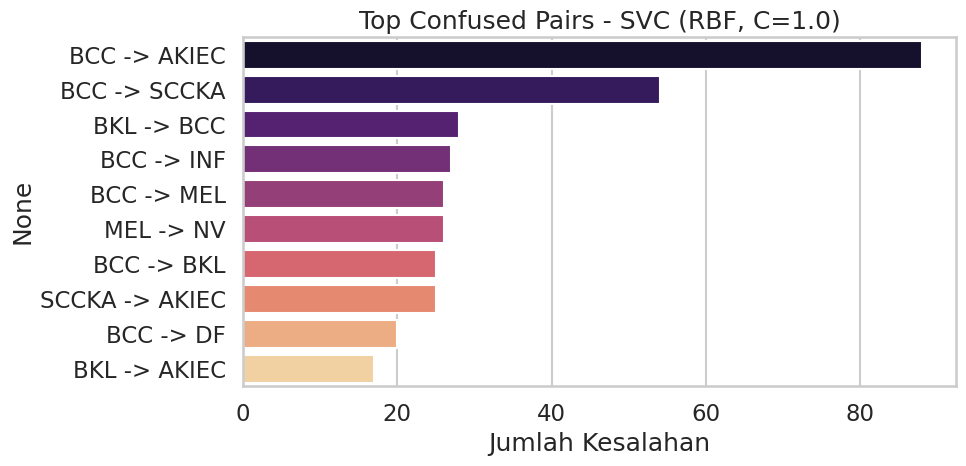


🖼️ Top 5 'High Confidence Errors' (Salah Tapi Yakin):


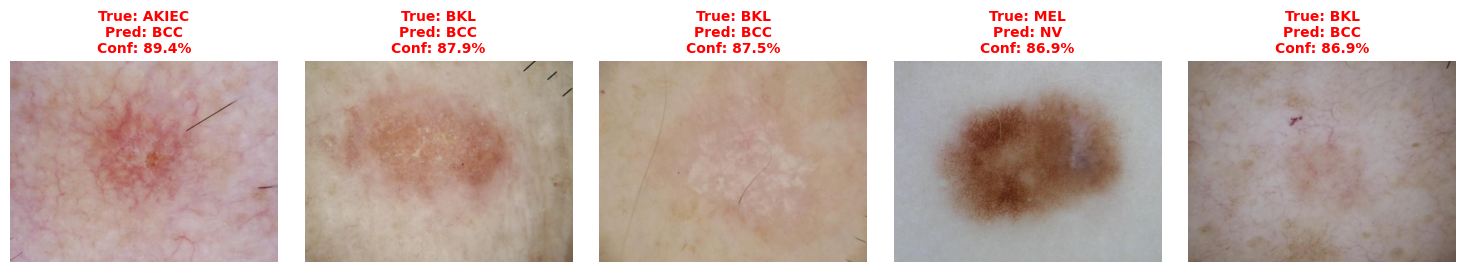

   🔍 Mengambil data untuk: ResNet-50 (Deep Learning (CNN))...
      🔄 Menjalankan inferensi ulang untuk mendapatkan Probabilitas...

🔍 ERROR ANALYSIS: ResNet-50

📋 Top 10 Paling Sering Tertukar (Confused Pairs):
| True Class   | Predicted   |   Error Count |
|:-------------|:------------|--------------:|
| BCC          | SCCKA       |            52 |
| MEL          | NV          |            31 |
| BKL          | BCC         |            25 |
| BKL          | SCCKA       |            22 |
| AKIEC        | SCCKA       |            20 |
| BCC          | AKIEC       |            19 |
| BCC          | BKL         |            17 |
| NV           | MEL         |            15 |
| AKIEC        | BKL         |            13 |
| SCCKA        | AKIEC       |            13 |


/tmp/ipykernel_17084/1240580379.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_confused, x='Error Count',


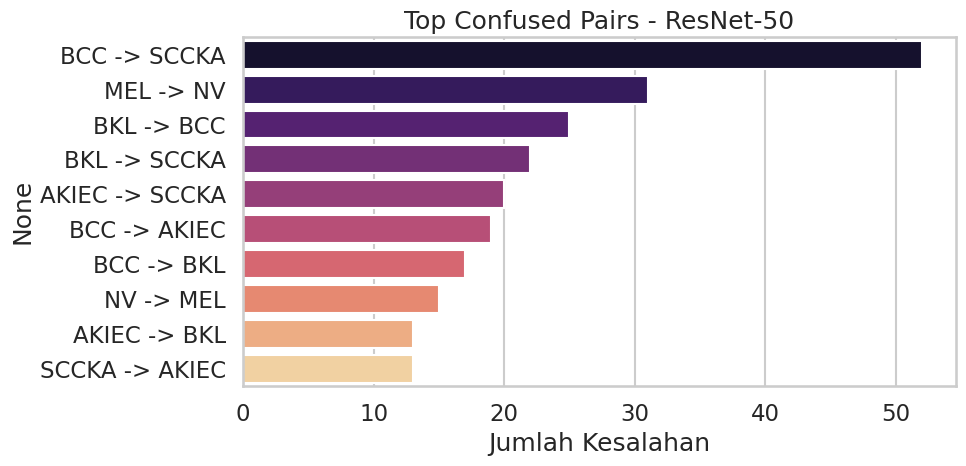


🖼️ Top 5 'High Confidence Errors' (Salah Tapi Yakin):


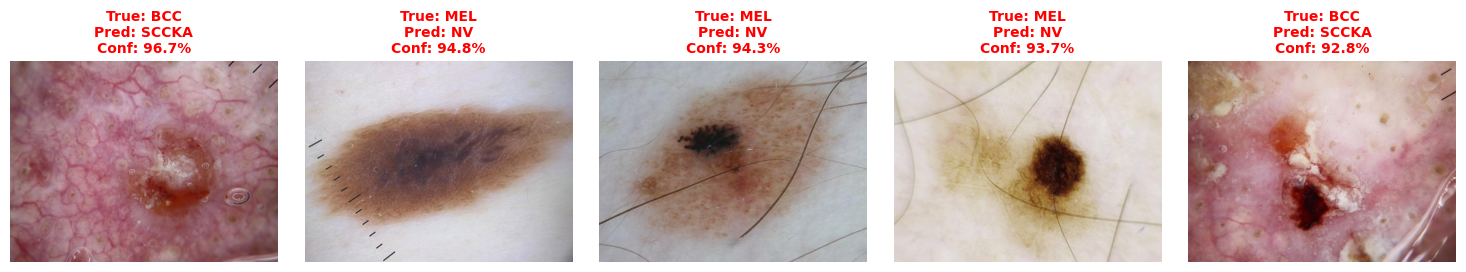

   🔍 Mengambil data untuk: Swin-T (Transformer)...
      🔄 Menjalankan inferensi ulang untuk mendapatkan Probabilitas...

🔍 ERROR ANALYSIS: Swin-T

📋 Top 10 Paling Sering Tertukar (Confused Pairs):
| True Class   | Predicted   |   Error Count |
|:-------------|:------------|--------------:|
| BCC          | DF          |            43 |
| NV           | MEL         |            34 |
| BCC          | SCCKA       |            27 |
| BKL          | BCC         |            24 |
| BCC          | INF         |            21 |
| BCC          | MEL         |            21 |
| MEL          | NV          |            18 |
| BCC          | AKIEC       |            18 |
| BKL          | MEL         |            18 |
| SCCKA        | BCC         |            16 |


/tmp/ipykernel_17084/1240580379.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_confused, x='Error Count',


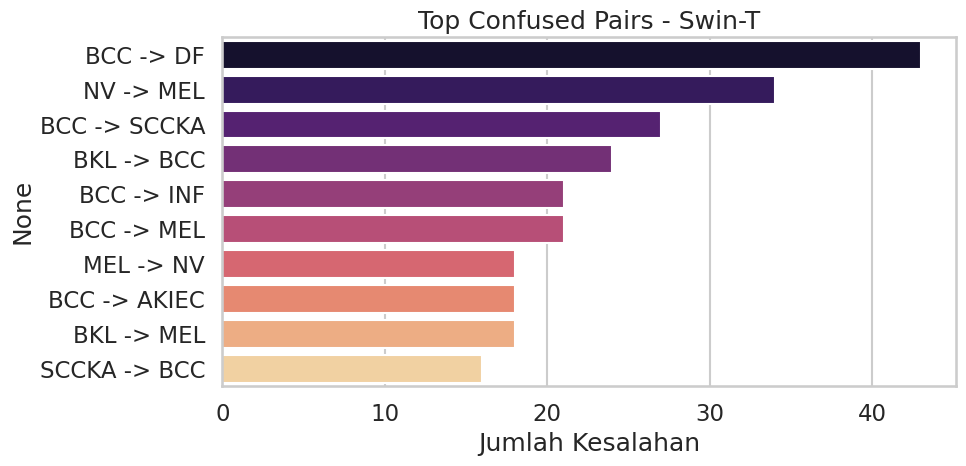


🖼️ Top 5 'High Confidence Errors' (Salah Tapi Yakin):


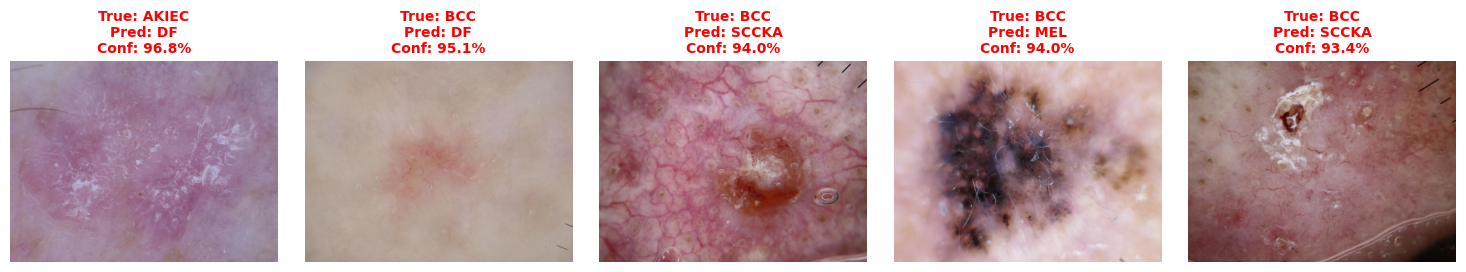

In [58]:
# ==============================================================================
# ERROR ANALYSIS MENDALAM (CONFUSED PAIRS & VISUALISASI)
# ==============================================================================
"""
DOKUMENTASI ANALISIS ERROR:
Modul ini melakukan investigasi kualitatif terhadap kegagalan model.

1. Top Confused Pairs (Kuantitatif):
   Mengidentifikasi pasangan kelas (Ground Truth vs Prediksi) yang paling sering 
   salah diklasifikasikan. Ini membantu mendeteksi bias sistematis (misal: 
   BCC sering dikira NV).

2. Worst Failures / High Confidence Errors (Kualitatif):
   Menampilkan sampel gambar di mana model melakukan kesalahan prediksi namun 
   dengan tingkat kepercayaan (confidence score) yang sangat tinggi. 
   Ini adalah kesalahan "fatal" yang perlu diinspeksi secara visual.
"""

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from PIL import Image 

def analyze_errors(model_name, preds, probs, targets, df_val, class_names=DIAGNOSIS_COLUMNS):
    """Menjalankan analisis error lengkap untuk satu model."""
    
    print(f"\n{'='*80}")
    print(f"🔍 ERROR ANALYSIS: {model_name}")
    print(f"{'='*80}")
    
    # Normalisasi input ke numpy array
    if torch.is_tensor(preds): preds = preds.cpu().numpy()
    if torch.is_tensor(targets): targets = targets.cpu().numpy()
    if probs is not None and torch.is_tensor(probs): probs = probs.cpu().numpy()
    
    # ---------------------------------------------------------
    # BAGIAN 1: TOP CONFUSED PAIRS
    # ---------------------------------------------------------
    cm = confusion_matrix(targets, preds)
    np.fill_diagonal(cm, 0) # Abaikan prediksi yang benar
    
    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm[i, j] > 0:
                pairs.append({
                    'True Class': class_names[i],
                    'Predicted': class_names[j],
                    'Error Count': cm[i, j]
                })
    
    # Tampilkan Top 10 Error
    if pairs:
        df_confused = pd.DataFrame(pairs).sort_values(by='Error Count', ascending=False).head(10)
        print("\n📋 Top 10 Paling Sering Tertukar (Confused Pairs):")
        print(df_confused.to_markdown(index=False))
        
        # Visualisasi Bar Plot
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df_confused, x='Error Count', 
                    y=df_confused.apply(lambda x: f"{x['True Class']} -> {x['Predicted']}", axis=1), 
                    palette='magma')
        plt.title(f"Top Confused Pairs - {model_name}")
        plt.xlabel("Jumlah Kesalahan")
        plt.tight_layout()
        plt.show()
    else:
        print("✅ Model sempurna! Tidak ada kesalahan yang ditemukan.")
    
    # ---------------------------------------------------------
    # BAGIAN 2: VISUALISASI "WORST FAILURES"
    # ---------------------------------------------------------
    if probs is not None:
        pred_confidences = np.max(probs, axis=1)
        incorrect_indices = np.where(preds != targets)[0]
        
        if len(incorrect_indices) > 0:
            incorrect_confidences = pred_confidences[incorrect_indices]
            
            # Urutkan berdasarkan confidence tertinggi (paling "yakin" tapi salah)
            sorted_idx_relative = np.argsort(incorrect_confidences)[::-1]
            top_fail_indices = incorrect_indices[sorted_idx_relative][:5] 
            
            print(f"\n🖼️ Top 5 'High Confidence Errors' (Salah Tapi Yakin):")
            
            fig = plt.figure(figsize=(15, 4))
            
            for i, idx in enumerate(top_fail_indices):
                ax = fig.add_subplot(1, 5, i+1)
                
                # Ambil path gambar dari DataFrame Validasi
                img_path = df_val.iloc[idx]['dermoscopic_full_path']
                
                try:
                    img = Image.open(img_path)
                    ax.imshow(img)
                except Exception:
                    ax.text(0.5, 0.5, "Image Not Found", ha='center')
                
                true_cls = class_names[targets[idx]]
                pred_cls = class_names[preds[idx]]
                conf = pred_confidences[idx] * 100
                
                ax.set_title(f"True: {true_cls}\nPred: {pred_cls}\nConf: {conf:.1f}%", 
                             color='red', fontsize=10, fontweight='bold')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
        else:
            print("✅ Tidak ada prediksi yang salah untuk divisualisasikan.")
    else:
        print("⚠️ Visualisasi 'High Confidence Errors' dilewati (Probabilitas tidak tersedia).")


# --- EKSEKUSI PADA MODEL JUARA ---
if 'champions_data' in locals() and 'val_df' in locals():
    for name, category in champions_data:
        # Gunakan fungsi smart fetch dari SEL 23
        preds, probs, targets = get_predictions_smart_final(name, category)
        
        if preds is not None and targets is not None:
            # Sinkronisasi panjang data
            min_len = min(len(preds), len(targets))
            preds = preds[:min_len]
            targets = targets[:min_len]
            if probs is not None: probs = probs[:min_len]
            
            analyze_errors(name, preds, probs, targets, val_df, DIAGNOSIS_COLUMNS)
else:
    print("❌ Data Juara atau DataFrame Validasi tidak ditemukan. Pastikan SEL 23 telah dijalankan.")